<a href="https://colab.research.google.com/github/shahkarKhan24/Shape-Deformation-and-Pytorch3d/blob/main/Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Shape Deformation Using 2D Guidance

**Abstract:**
Shape deformation refers to the changes or alterations in the shape or geometry of three-dimensional (3D) objects or surfaces by
applying a transformation to its components. 3D data is more complex than 2D images you may face several challenges including 3D
data representation, batching, and speed etc. there is much more work done on 3D to 2d shape deformation, but in this paper we will be
working on shape deformation of 3D object using only 2D guidance, means we have to use images or similar input to deform our 3D
object as per our requirement. We will also try to integrate adversarial loss during our training to get efficient result or may just to see
the difference between the two methods.

In [ ]:

 !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

  Cloning https://github.com/facebookresearch/pytorch3d.git (to revision stable) to /tmp/pip-req-build-xg7rng8k
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-xg7rng8k
  Running command git checkout -q f34104cf6ebefacd7b7e07955ee7aaa823e616ac
  Resolved https://github.com/facebookresearch/pytorch3d.git to commit f34104cf6ebefacd7b7e07955ee7aaa823e616ac
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch3d: filename=pytorch3d-0.7.6-cp310-cp310-linux_x86_64.whl size=56754251 sha256=a47508072ae06a0fd612a1c1830f01372876d2fc86ae86d52b9cc4099586438b
  Stored in directory: /tmp/pip-ephem-wheel-cache-rpl2o9q5/wheels/39/5f/20/2d3b6f3a35a60bdc0ba3c19da94340db9596637

Inporting all the necessary


In [ ]:
import os
import torch
import sys
from pytorch3d.io import load_obj, save_obj
import torch.nn as nn
import torch.optim as optim
# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, save_obj
from pytorch3d.structures import Meshes
from pytorch3d.utils import ico_sphere
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.loss import (
    chamfer_distance,
    mesh_edge_loss,
    mesh_laplacian_smoothing,
    mesh_normal_consistency,
)
import numpy as np
from tqdm.notebook import tqdm
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

# Set the device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("WARNING: CPU only, this will be slow!")

In [ ]:
# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    PointLights,
    DirectionalLights,
    Materials,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    SoftPhongShader,
    SoftSilhouetteShader,
    SoftPhongShader,
    TexturesVertex
)

# add path for demo utils functions
import sys
import os
sys.path.append(os.path.abspath(''))

downloading .obj file for ur target mesh

In [ ]:
!wget https://dl.fbaipublicfiles.com/pytorch3d/data/dolphin/dolphin.obj

--2024-05-21 15:18:45--  https://dl.fbaipublicfiles.com/pytorch3d/data/dolphin/dolphin.obj
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.156.60.69, 108.156.60.51, 108.156.60.36, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|108.156.60.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 156763 (153K) [text/plain]
Saving to: ‘dolphin.obj’

dolphin.obj         100%[===================>] 153.09K  --.-KB/s    in 0.01s   

2024-05-21 15:18:45 (13.7 MB/s) - ‘dolphin.obj’ saved [156763/156763]



In [ ]:
# Load the dolphin mesh.
trg_obj = 'dolphin.obj'

In [ ]:
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
from plot_image_grid import image_grid

--2024-05-21 15:18:57--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1608 (1.6K) [text/plain]
Saving to: ‘plot_image_grid.py’

plot_image_grid.py  100%[===================>]   1.57K  --.-KB/s    in 0s      

2024-05-21 15:18:57 (32.4 MB/s) - ‘plot_image_grid.py’ saved [1608/1608]



In [ ]:
# We read the target 3D model using load_obj
verts, faces, aux = load_obj(trg_obj)

/usr/local/lib/python3.10/dist-packages/pytorch3d/io/obj_io.py:544: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


In [ ]:
faces_idx = faces.verts_idx.to(device)
verts = verts.to(device)

In [ ]:
center = verts.mean(0)
verts = verts - center
scale = max(verts.abs().max(0)[0])
verts = verts / scale

In [ ]:

# We construct a Meshes structure for the target mesh
trg_mesh = Meshes(verts=[verts], faces=[faces_idx])

In [ ]:
# We initialize the source shape to be a sphere of radius 1
src_mesh = ico_sphere(4, device)

In [ ]:
# the number of different viewpoints from which we want to render the mesh.
num_views = 20

In [ ]:
# Get a batch of viewing angles.
elev = torch.linspace(0, 360, num_views)
azim = torch.linspace(-180, 180, num_views)

# Place a point light in front of the object. As mentioned above, the front of
# the cow is facing the -z direction.
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)
# We arbitrarily choose one particular view that will be used to visualize
# results
camera = FoVPerspectiveCameras(device=device, R=R[None, 1, ...],
                                  T=T[None, 1, ...])

In [ ]:

raster_settings = RasterizationSettings(
    image_size=128,
    blur_radius=0.0,
    faces_per_pixel=1,
)

renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera,
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device,
        cameras=camera,
        lights=lights
    )
)

In [ ]:

meshes =trg_mesh.extend(num_views)

In [ ]:
target_cameras = [FoVPerspectiveCameras(device=device, R=R[None, i, ...],
                                           T=T[None, i, ...]) for i in range(num_views)]

In [ ]:
# Rasterization settings for silhouette rendering
sigma = 1e-4
raster_settings_silhouette = RasterizationSettings(
    image_size=128,
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma,
    faces_per_pixel=50,
)

# Silhouette renderer
renderer_silhouette = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera,
        raster_settings=raster_settings_silhouette
    ),
    shader=SoftSilhouetteShader()
)

# Render silhouette images.  The 3rd channel of the rendering output is
# the alpha/silhouette channel
silhouette_images = renderer_silhouette(meshes, cameras=cameras, lights=lights)
target_silhouette = [silhouette_images[i, ..., 3] for i in range(num_views)]


To create a dataset we use pytorch3D , first we load target object which is an .obj file, which is then converted into a vertices and meshes.We then scale normalize and center the target mesh to fit in a sphere of radius 1 centered at (0,0,0).It should be noted that normalizing the target mesh, speeds up the optimization but is not necessary. since our target mesh is normalize it make sense that our source mesh which we want to deformed must also be normalize. In this project we used a shpere of radius 1 for simplicity but the source mesh can be of any shape.after that we use pytorcg3d resterizing
 module define the settings for rasterization and shading. Here we set the output image to be of size 128X128. The differential silhouette renderer where we can sample different camera positions that give us multiple viewpoint of target mesh and then We render a synthetic dataset of  silhouette images.

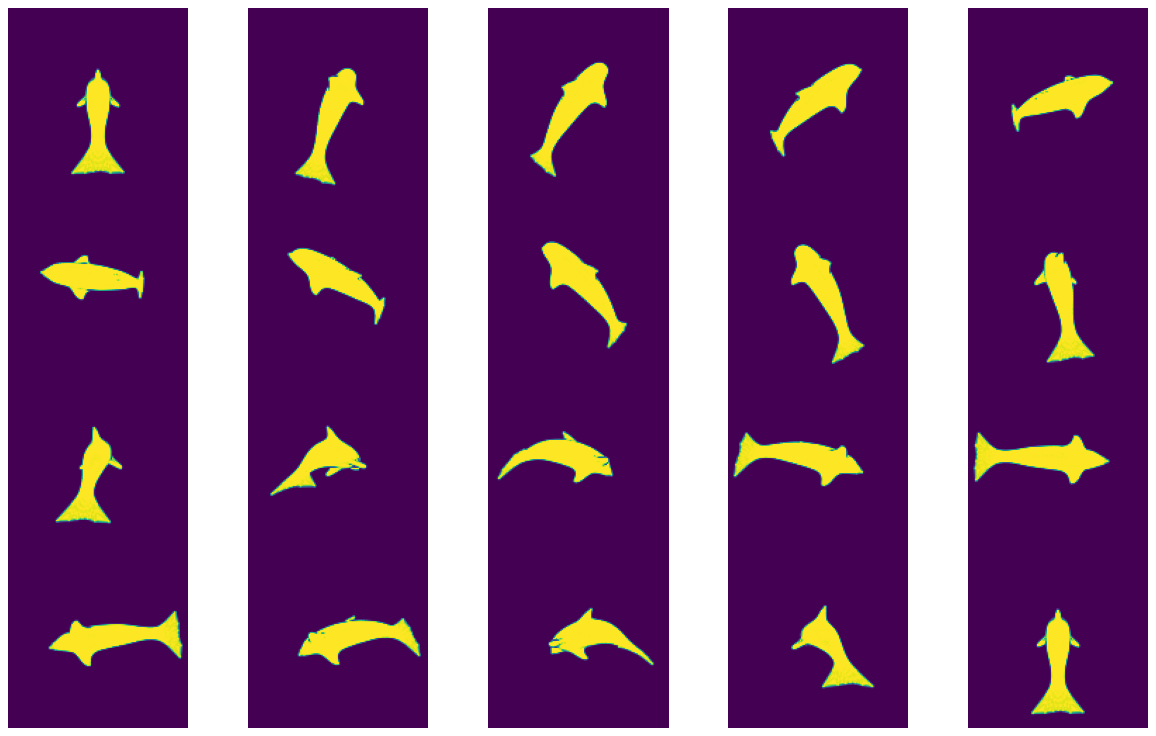

In [ ]:
# Visualize silhouette images
image_grid(silhouette_images.cpu().numpy(), rows=4, cols=5, rgb=False)
plt.show()

For visualization

In [ ]:
#  Show a visualization comparing the rendered predicted mesh to the ground truth
# mesh
def visualize_prediction(predicted_mesh, renderer=renderer_silhouette,
                         target_image=target_silhouette[1],
                         silhouette=False):
    inds = 3 if silhouette else range(3)
    with torch.no_grad():
        predicted_images = renderer(predicted_mesh)
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(predicted_images[0, ..., inds].cpu().detach().numpy())
    plt.title('Predicted Image')


    plt.subplot(1, 2, 2)
    plt.imshow(target_image.cpu().detach().numpy())
    plt.title('Target Image')
    plt.axis("off")

# Plot losses as a function of optimization iteration
def plot_losses(losses):
    fig = plt.figure(figsize=(13, 5))
    ax = fig.gca()
    for k, l in losses.items():
        ax.plot(l['values'], label=k + " loss")
    ax.legend(fontsize="16")
    ax.set_xlabel("Iteration", fontsize="16")
    ax.set_ylabel("Loss", fontsize="16")
    ax.set_title("Loss vs iterations", fontsize="16")

In [ ]:
def plot_pointcloud(mesh, title=""):
    # Sample points uniformly from the surface of the mesh.
    points = sample_points_from_meshes(mesh, 5000)
    x, y, z = points.clone().detach().cpu().squeeze().unbind(1)
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter3D(x, z, -y)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title(title)
    ax.view_init(190, 30)
    plt.show()

In [ ]:
# We initialize the source shape to be a sphere of radius 1.
src_mesh = ico_sphere(4, device)

In [ ]:

sigma = 1e-4
raster_settings_soft = RasterizationSettings(
    image_size=128,
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma,
    faces_per_pixel=50,
)

# Silhouette renderer
renderer_silhouette = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera,
        raster_settings=raster_settings_soft
    ),
    shader=SoftSilhouetteShader()
)

# **First Baseline Approach**

We started with the simple approach first, after creating our own dataset using pytorch3D renderer as mentioned earlier and shown in figure 1.2 we first load a random source mesh that need to be deformed to our target mesh, in our case we are loading a spherical source mesh, but it can be of any shape. The optimizer we choose in this case is SGD optimizer with momentum = 0.9 and learning rate =1. After that during our optimization loop we offset vertices of our source mesh and save it in a new mesh, here the vertices that have been offset or deformed are learnable parameters. Means model is trying to learn in each iteration which vertices of our source mesh to deform. After this step we calculate four different losses mentioned in section 3.2. different weightage was given to each loss which was finalized through grid search after many experiments. The 2D images of new source mesh was rendered to calculate the silhouette loss by comparing it with 2D images of target mesh. The optimization loop was run for 2000 iteration. We try to monitor the losses and visualize the result during the training as well as in the end of the training. For visualization in 3D the mesh was simply converted into point clouds and then plotted, we also visualize it in 2D from a single view for both target mesh and source mesh to get a better picture of the results.

In [ ]:
# Number of views to optimize over in each SGD iteration
num_views_per_iteration = 2
# Number of optimization steps
Niter = 2000
# Plot period for the losses
plot_period = 100

%matplotlib inline

# Optimize using rendered silhouette image loss, mesh edge loss, mesh normal
# consistency, and mesh laplacian smoothing
losses = {"silhouette": {"weight": 1.0, "values": []},
          "edge": {"weight": 1.0, "values": []},
          "normal": {"weight": 0.01, "values": []},
          "laplacian": {"weight": 1.0, "values": []},
         }

# Losses to smooth / regularize the mesh shape
def update_mesh_shape_prior_losses(mesh, loss):
    # and (b) the edge length of the predicted mesh
    loss["edge"] = mesh_edge_loss(mesh)

    # mesh normal consistency
    loss["normal"] = mesh_normal_consistency(mesh)

    # mesh laplacian smoothing
    loss["laplacian"] = mesh_laplacian_smoothing(mesh, method="uniform")

# We will learn to deform the source mesh by offsetting its vertices
# The shape of the deform parameters is equal to the total number of vertices in
# src_mesh
verts_shape = src_mesh.verts_packed().shape
deform_verts = torch.full(verts_shape, 0.0, device=device, requires_grad=True)

# The optimizer
optimizer = torch.optim.SGD([deform_verts], lr=1.0, momentum=0.9)

  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch3d/ops/laplacian_matrices.py:49: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:618.)
  A = torch.sparse.FloatTensor(idx, ones, (V, V))


At Iteration 0: 



<IPython.core.display.Javascript object>

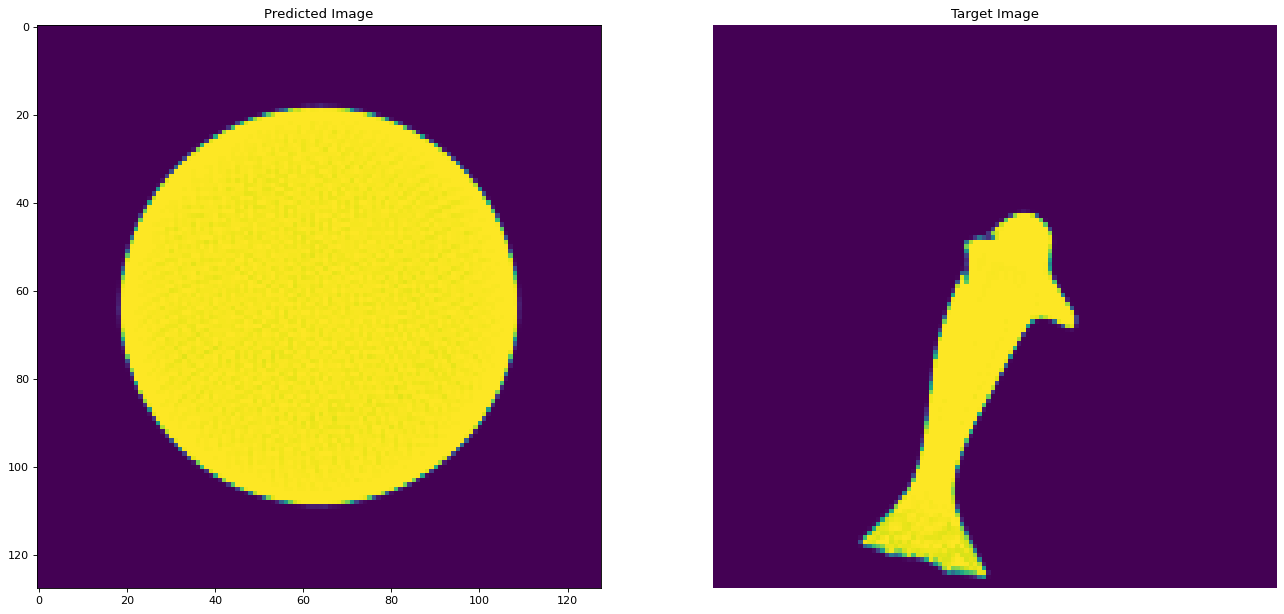

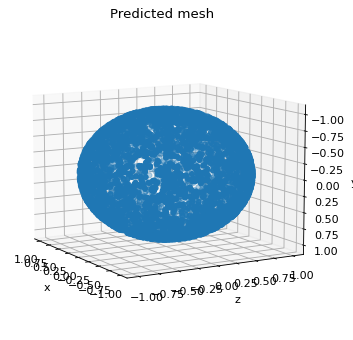

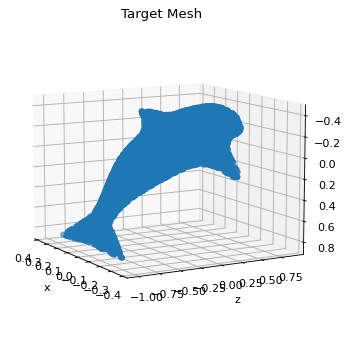

Visualizing Predicted Mesh and Target mesh as point_cloud 
At Iteration 100: 



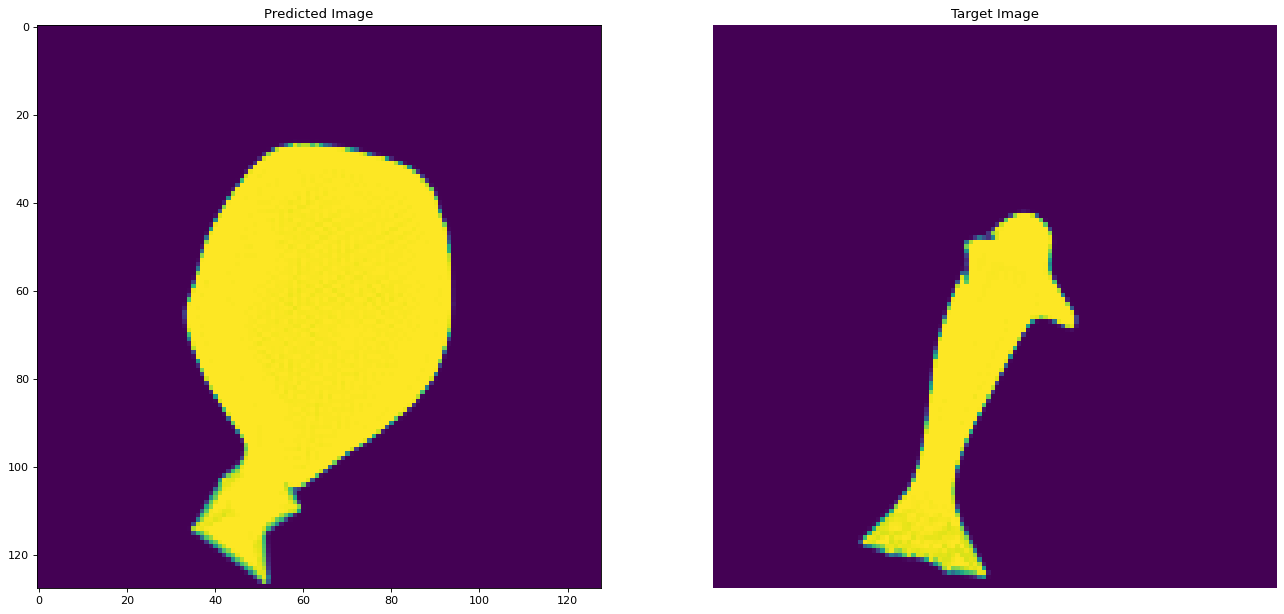

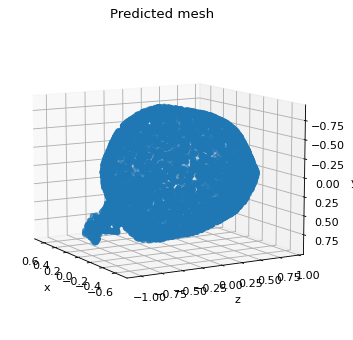

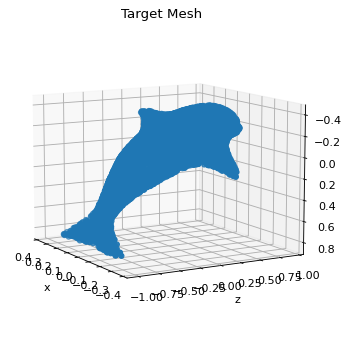

Visualizing Predicted Mesh and Target mesh as point_cloud 
At Iteration 200: 



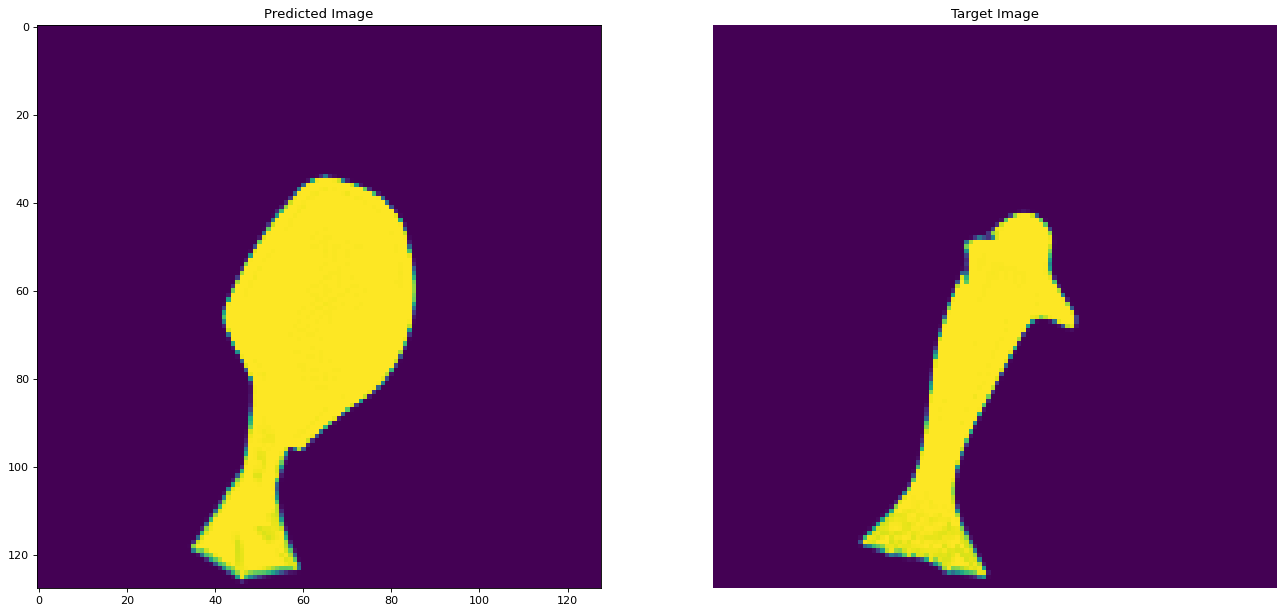

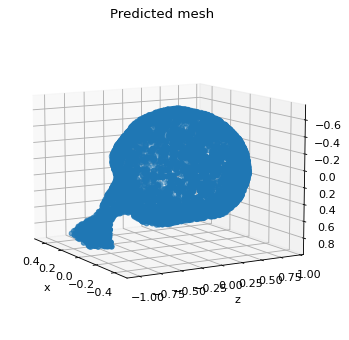

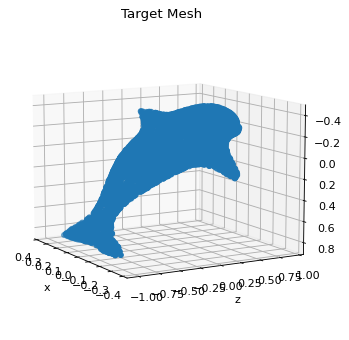

Visualizing Predicted Mesh and Target mesh as point_cloud 
At Iteration 300: 



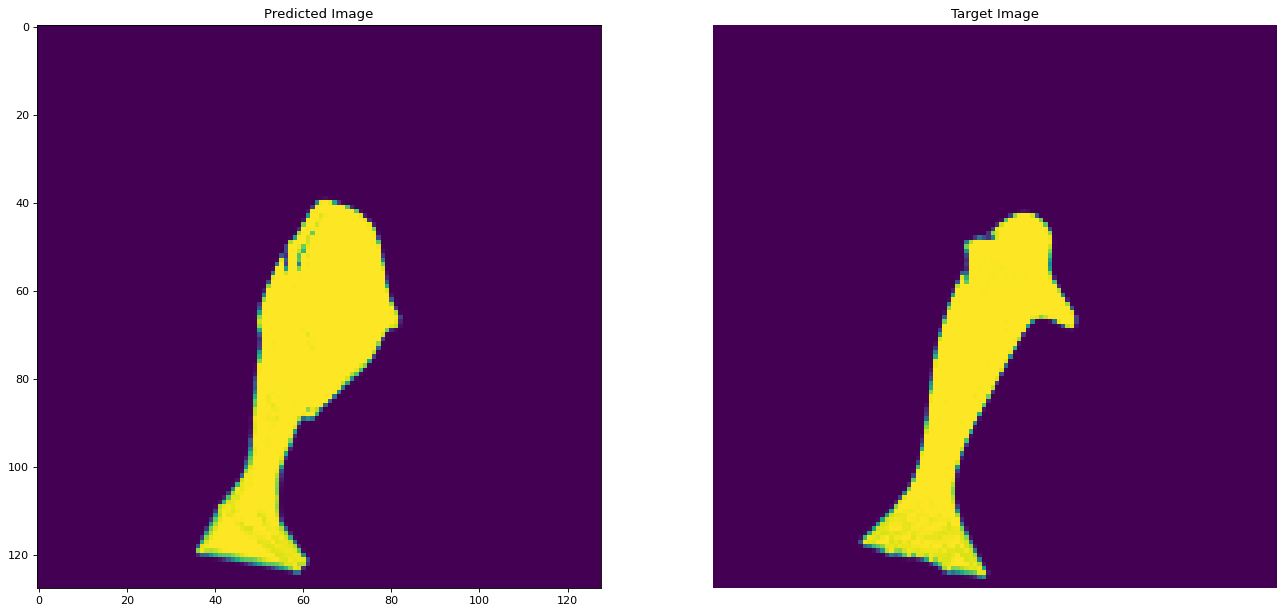

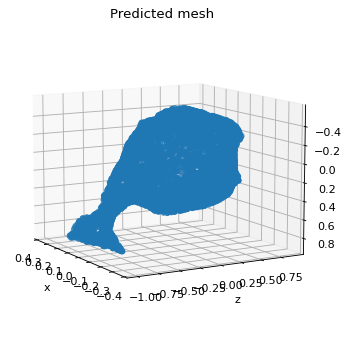

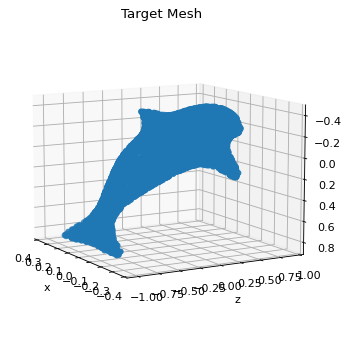

Visualizing Predicted Mesh and Target mesh as point_cloud 
At Iteration 400: 



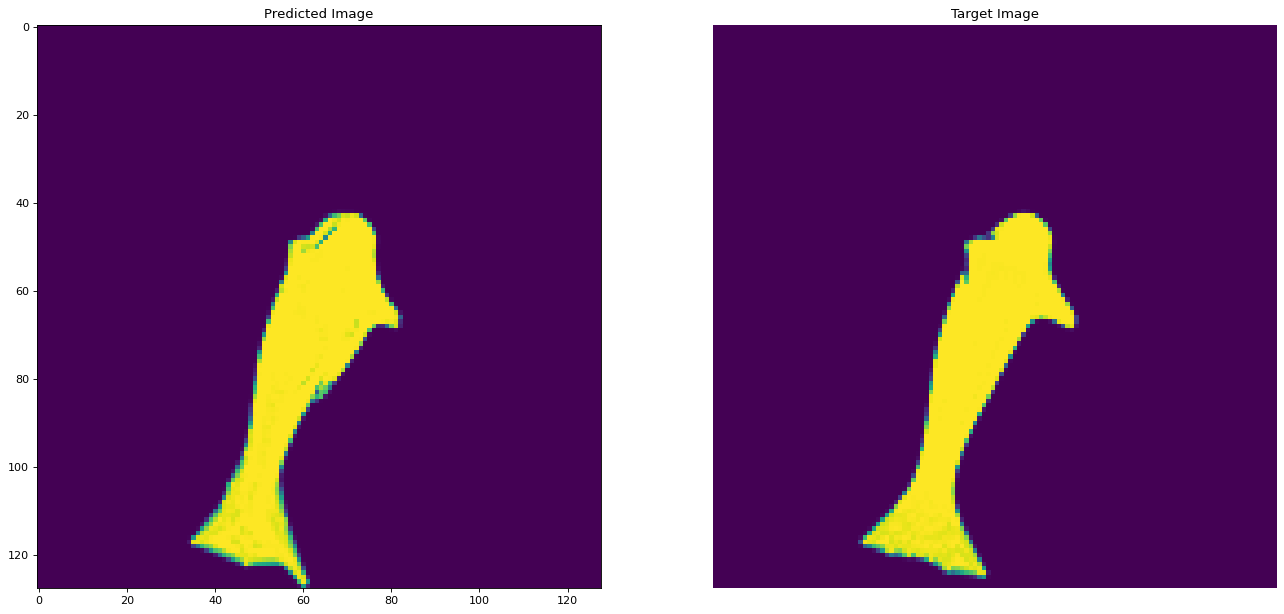

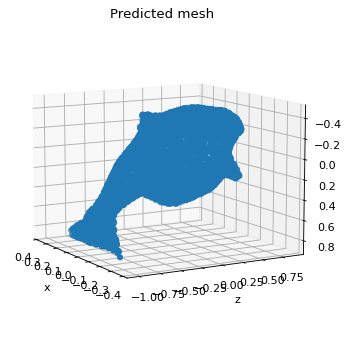

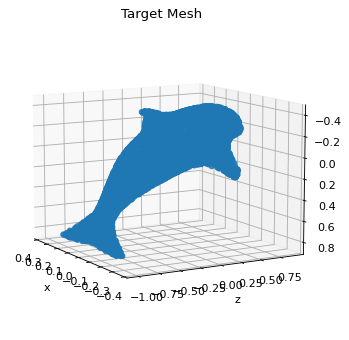

Visualizing Predicted Mesh and Target mesh as point_cloud 
At Iteration 500: 



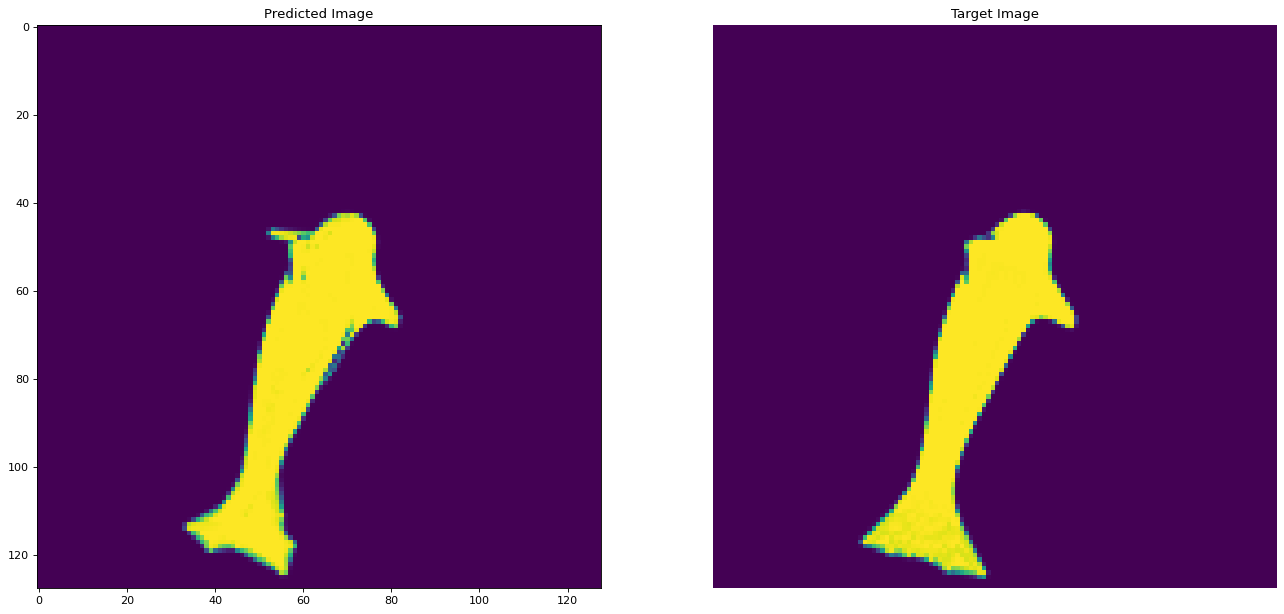

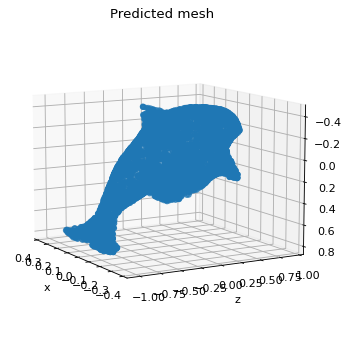

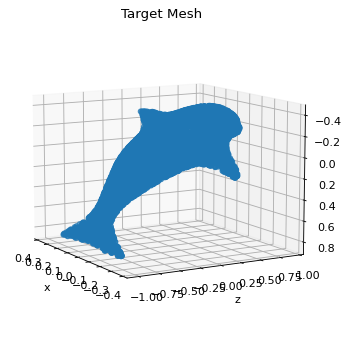

Visualizing Predicted Mesh and Target mesh as point_cloud 
At Iteration 600: 



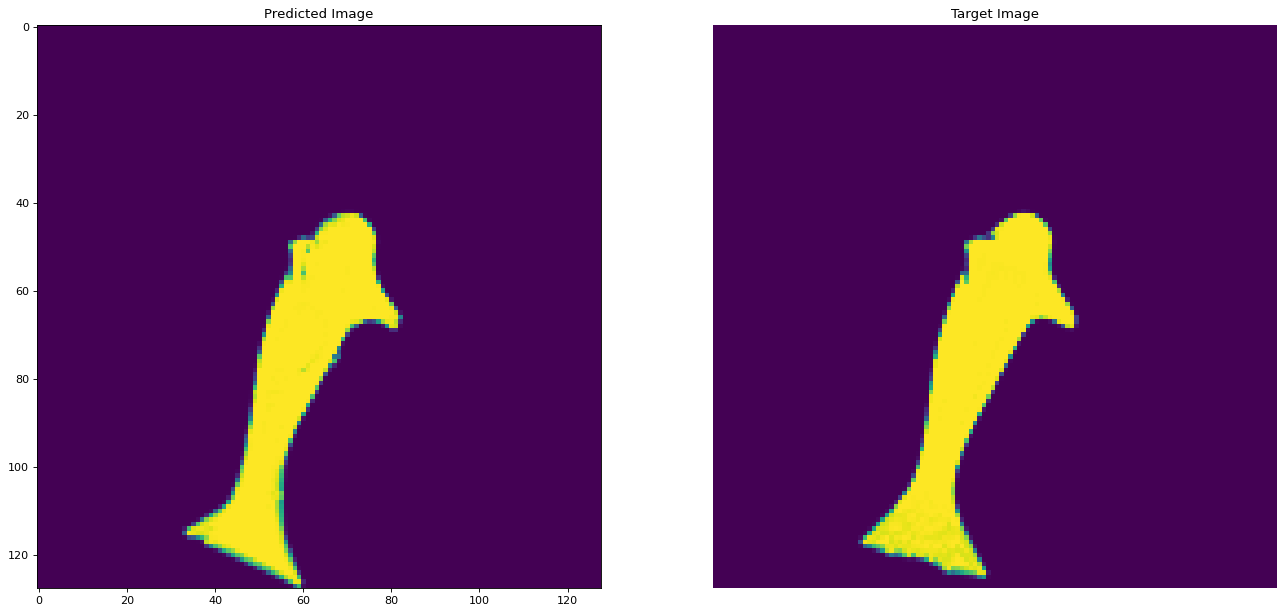

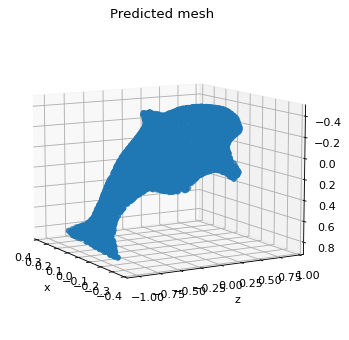

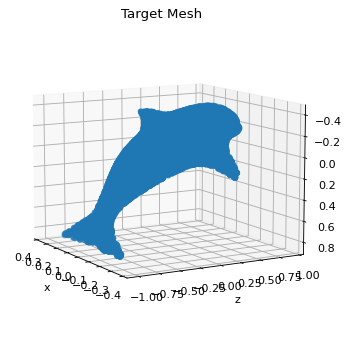

Visualizing Predicted Mesh and Target mesh as point_cloud 
At Iteration 700: 



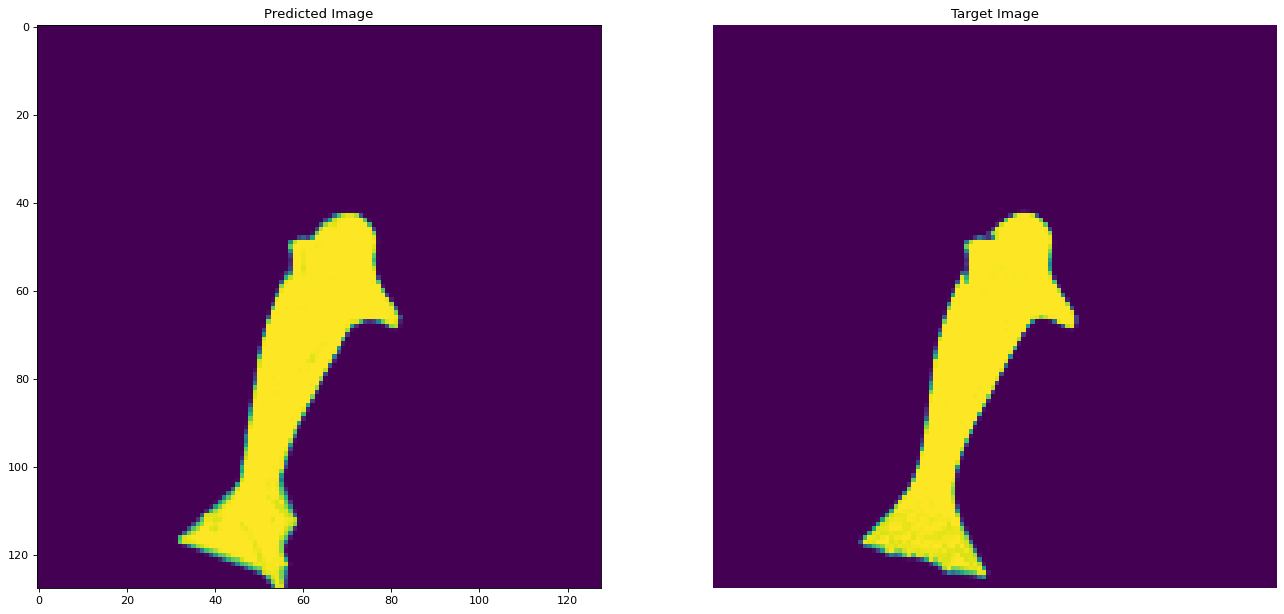

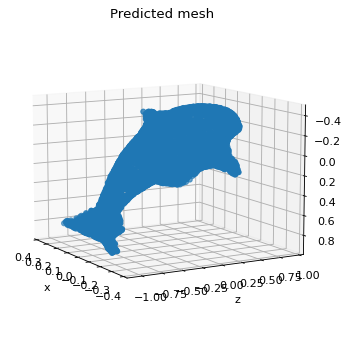

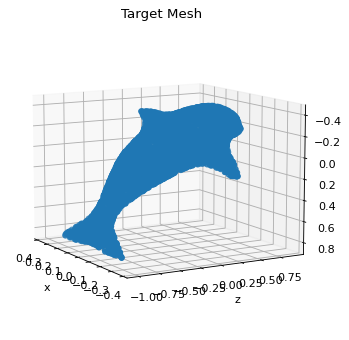

Visualizing Predicted Mesh and Target mesh as point_cloud 
At Iteration 800: 



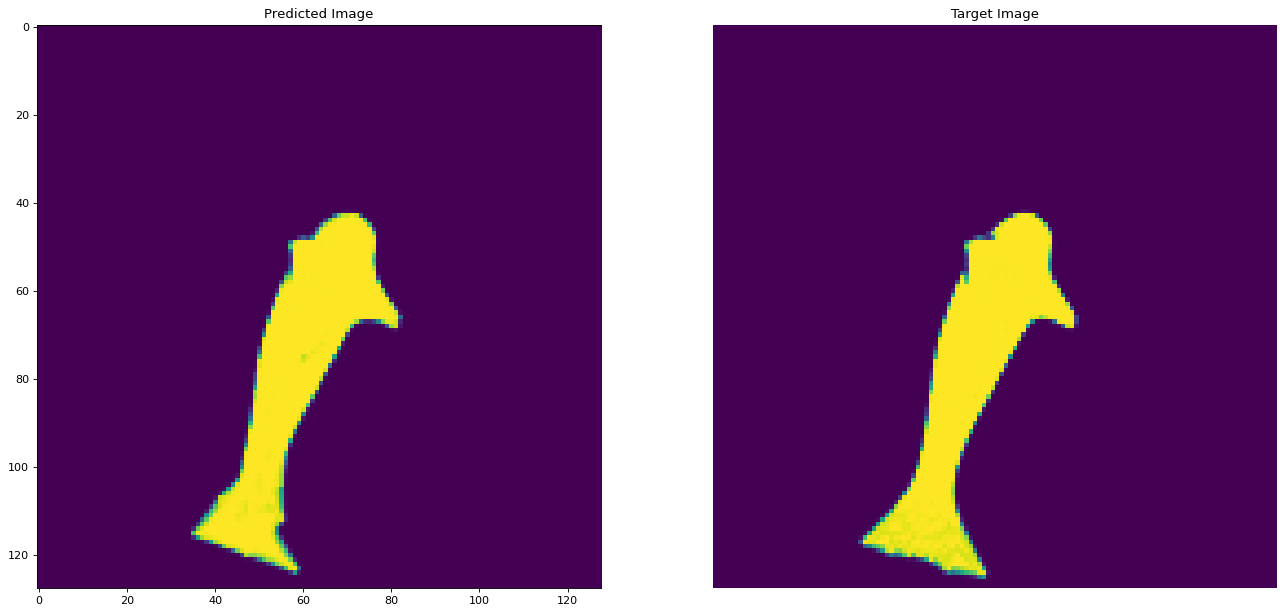

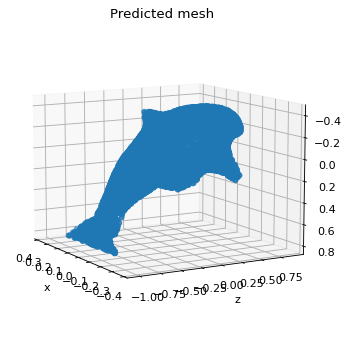

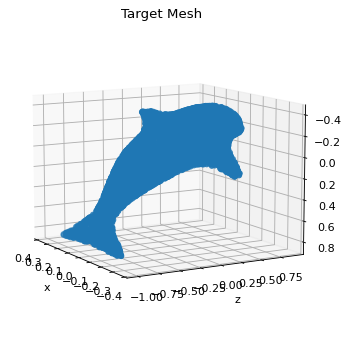

Visualizing Predicted Mesh and Target mesh as point_cloud 
At Iteration 900: 



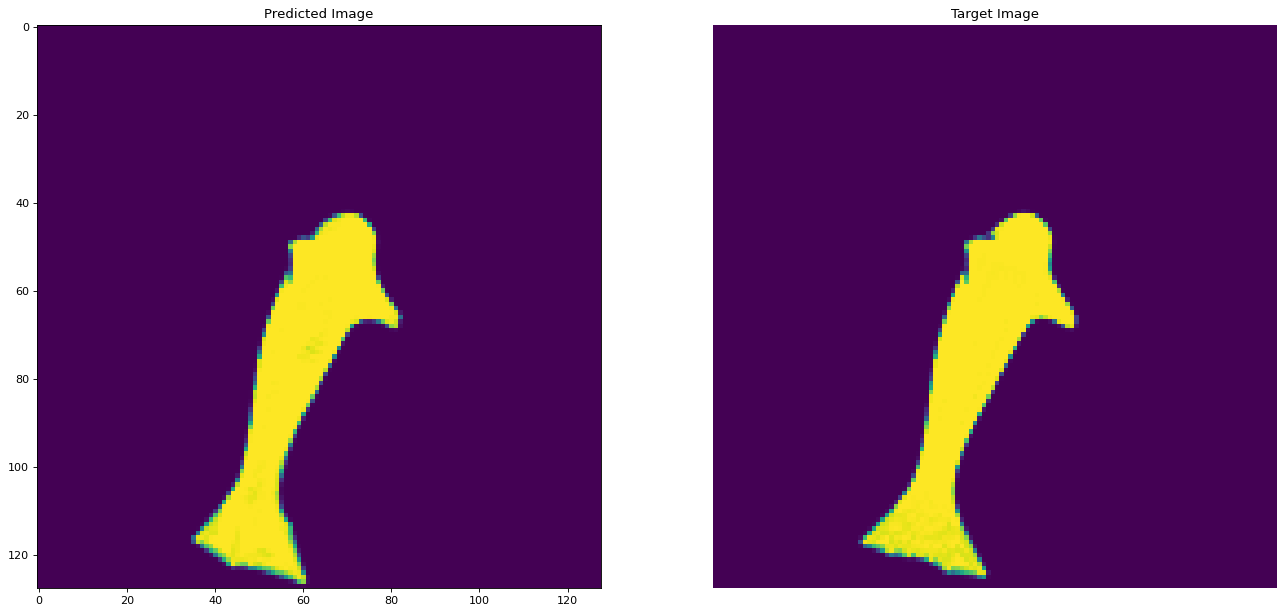

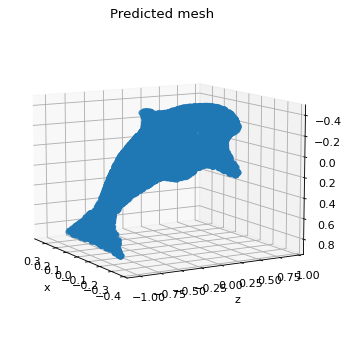

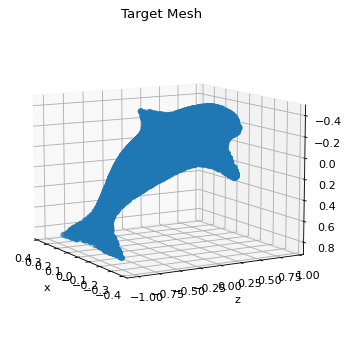

Visualizing Predicted Mesh and Target mesh as point_cloud 
At Iteration 1000: 



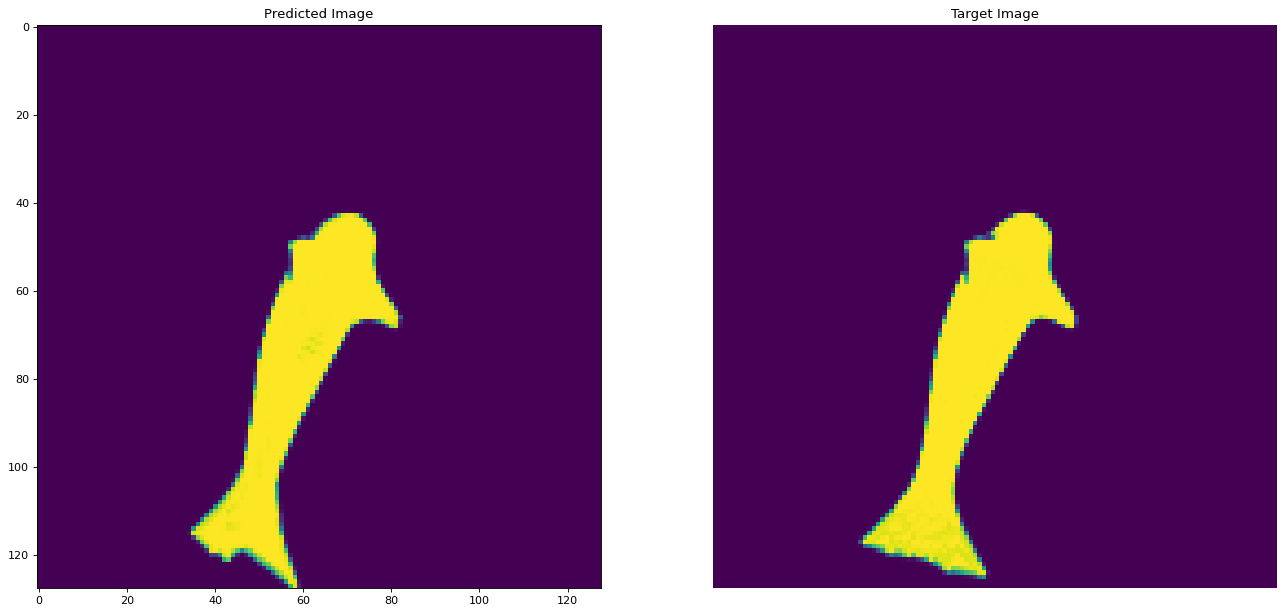

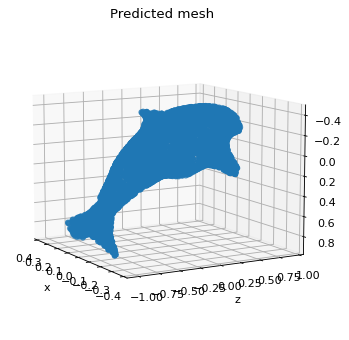

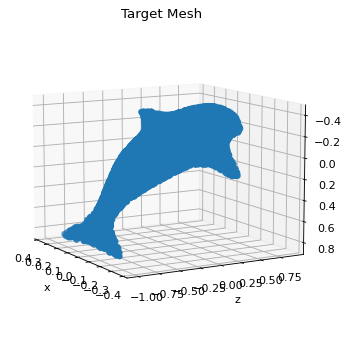

Visualizing Predicted Mesh and Target mesh as point_cloud 
At Iteration 1100: 



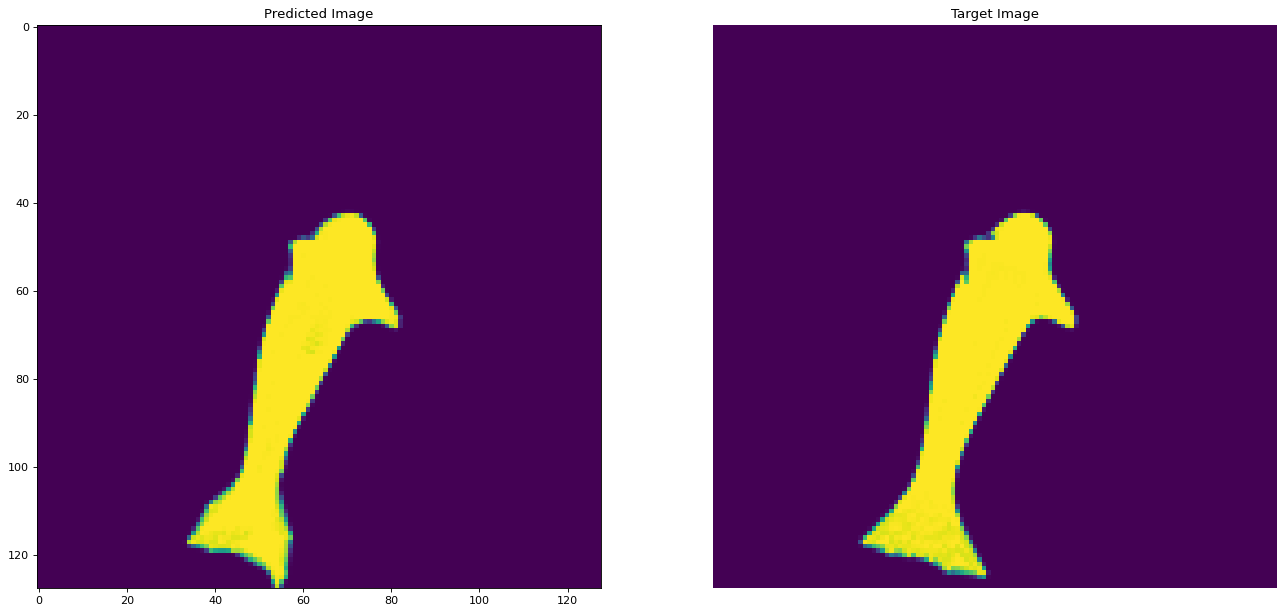

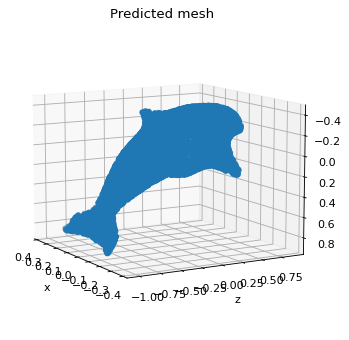

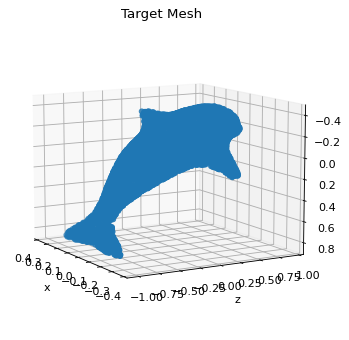

Visualizing Predicted Mesh and Target mesh as point_cloud 
At Iteration 1200: 



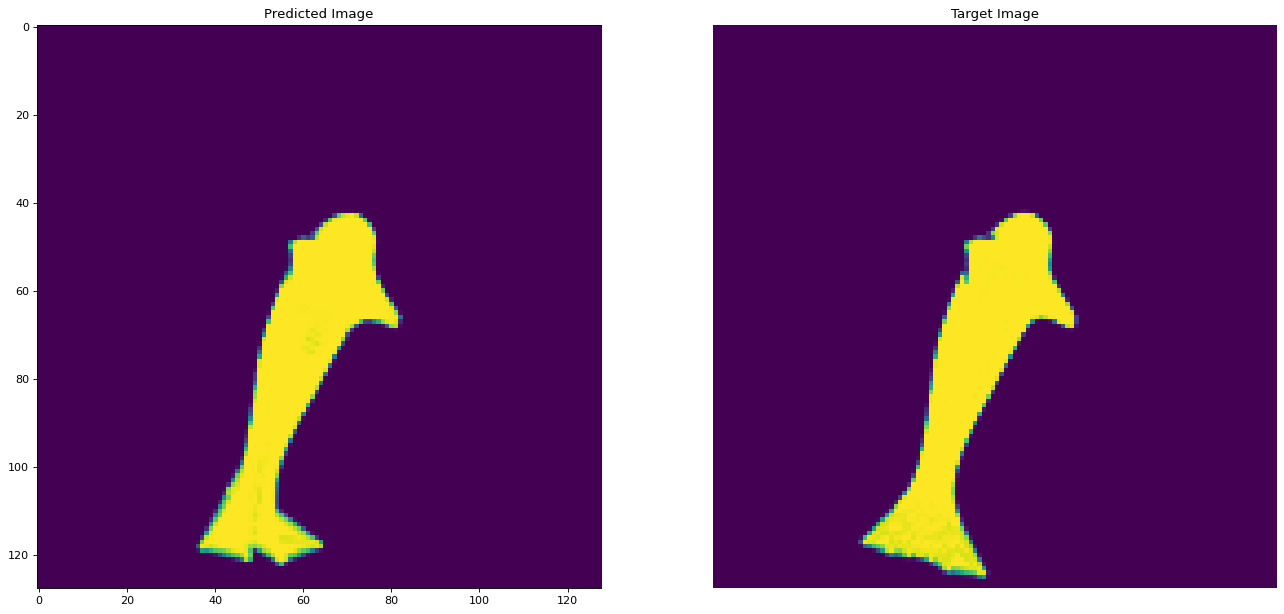

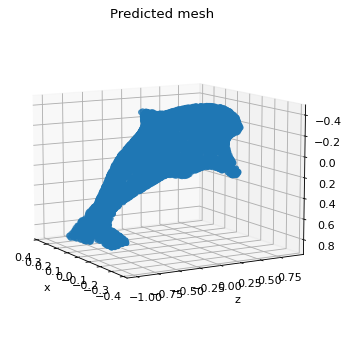

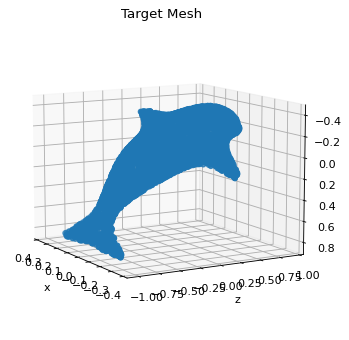

Visualizing Predicted Mesh and Target mesh as point_cloud 
At Iteration 1300: 



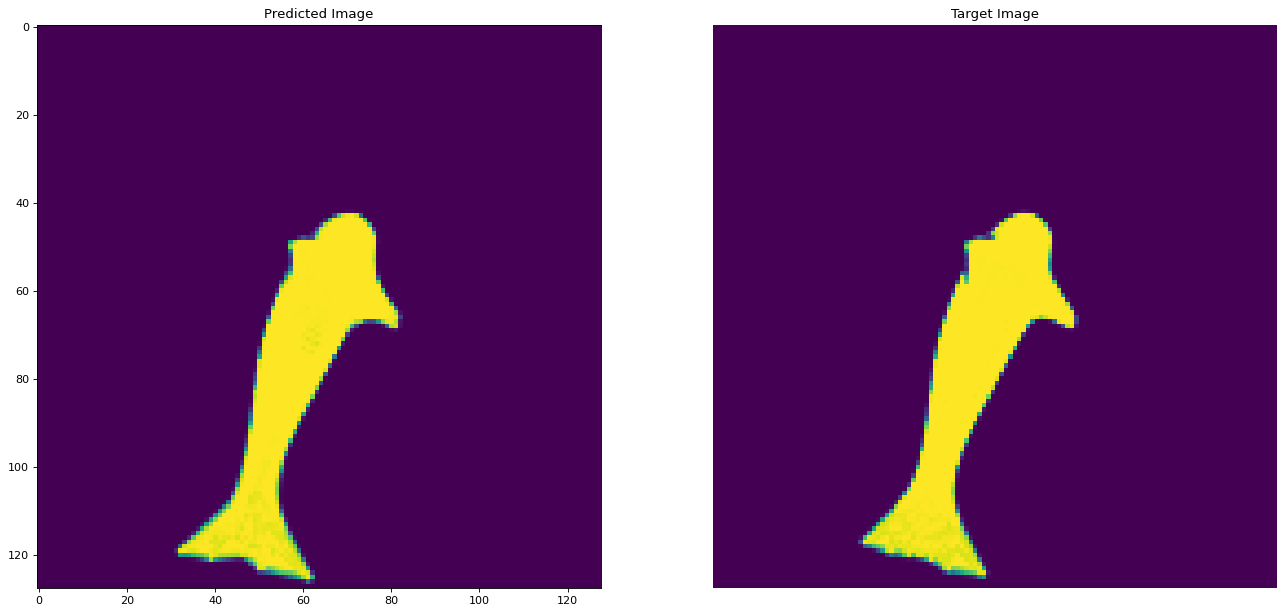

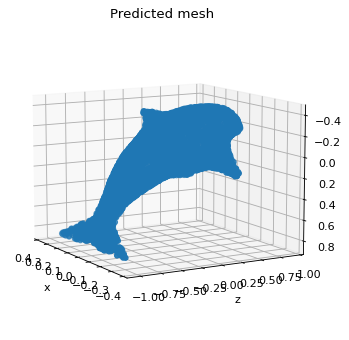

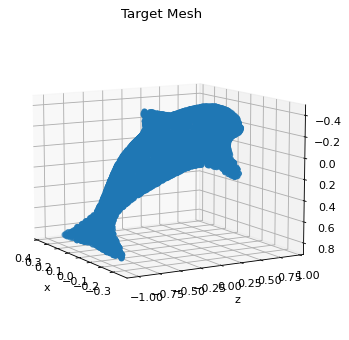

Visualizing Predicted Mesh and Target mesh as point_cloud 
At Iteration 1400: 



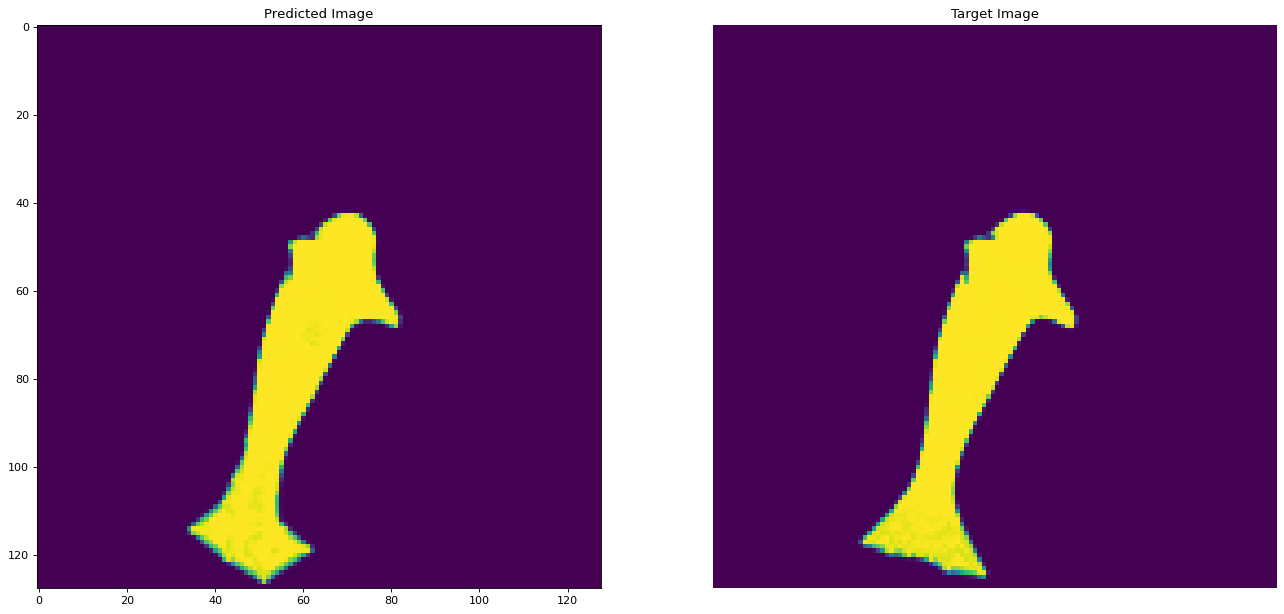

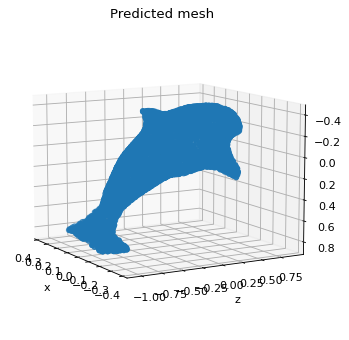

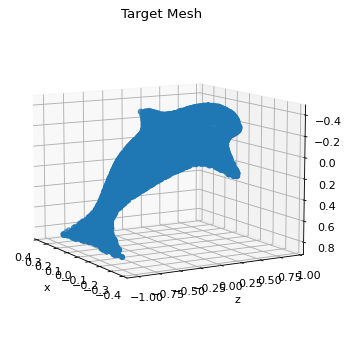

Visualizing Predicted Mesh and Target mesh as point_cloud 
At Iteration 1500: 



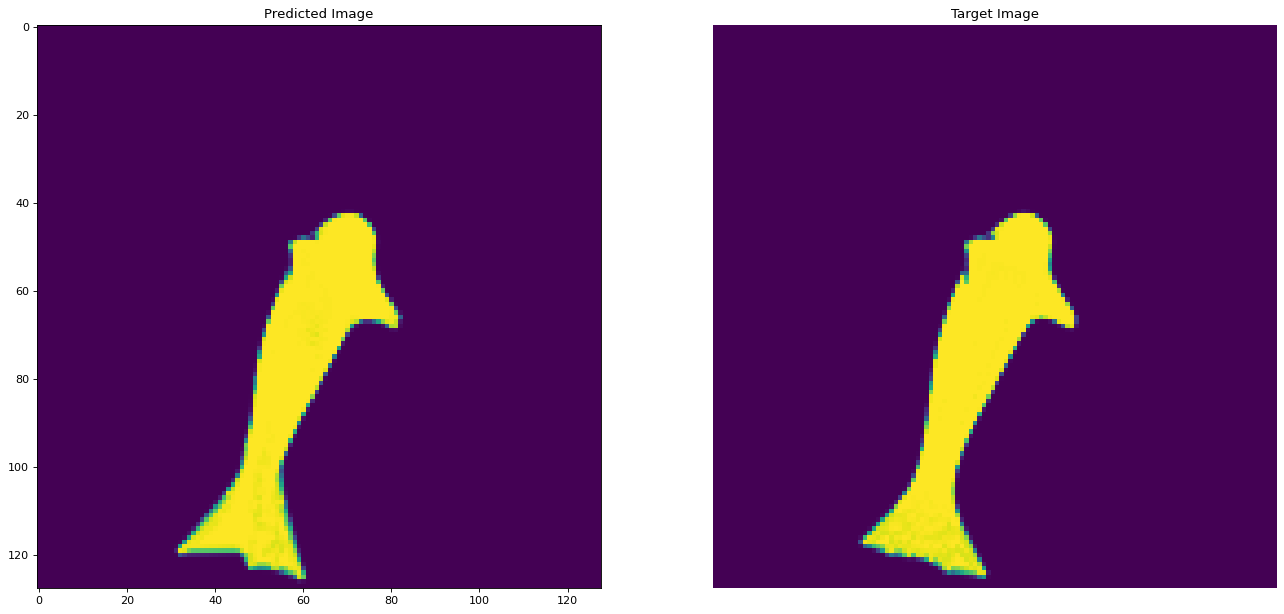

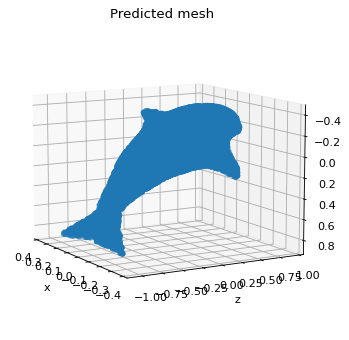

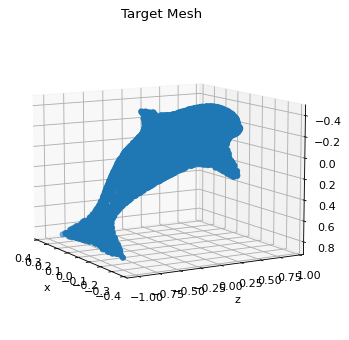

Visualizing Predicted Mesh and Target mesh as point_cloud 
At Iteration 1600: 



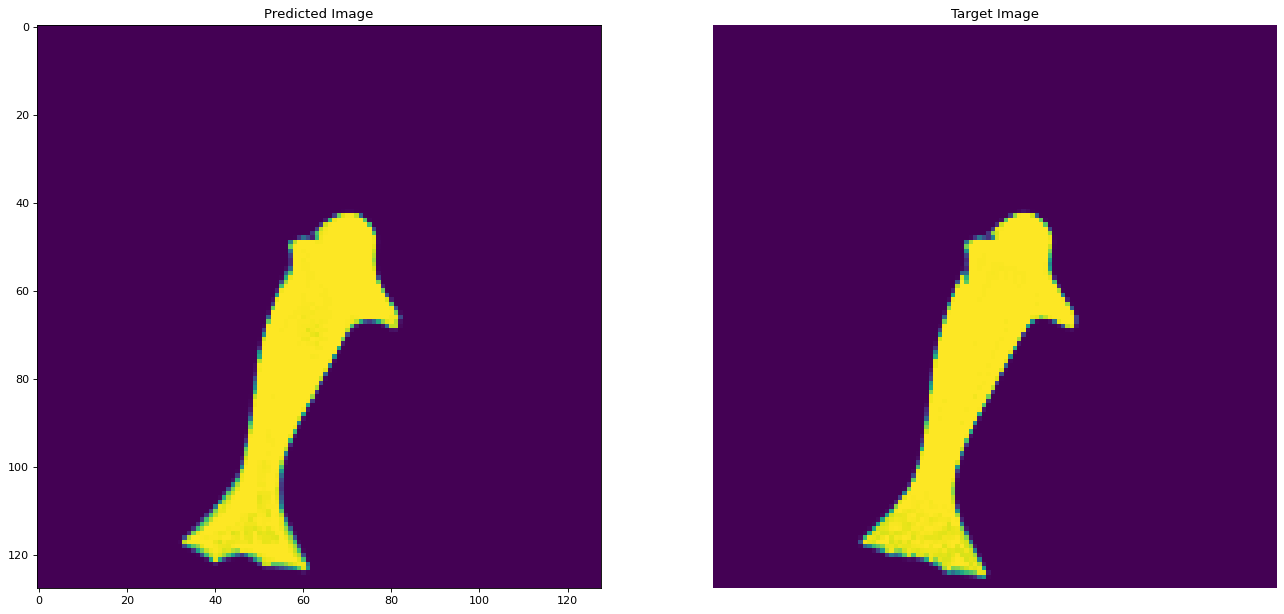

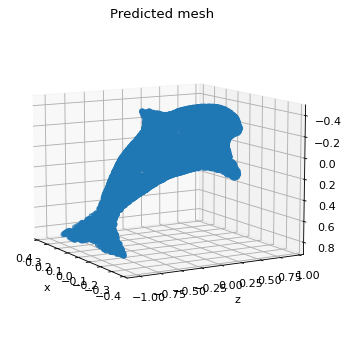

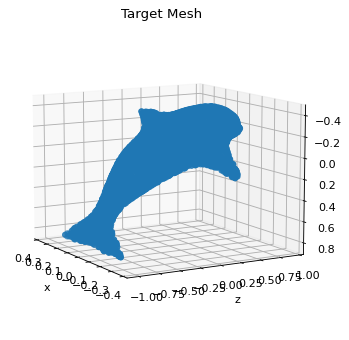

Visualizing Predicted Mesh and Target mesh as point_cloud 
At Iteration 1700: 



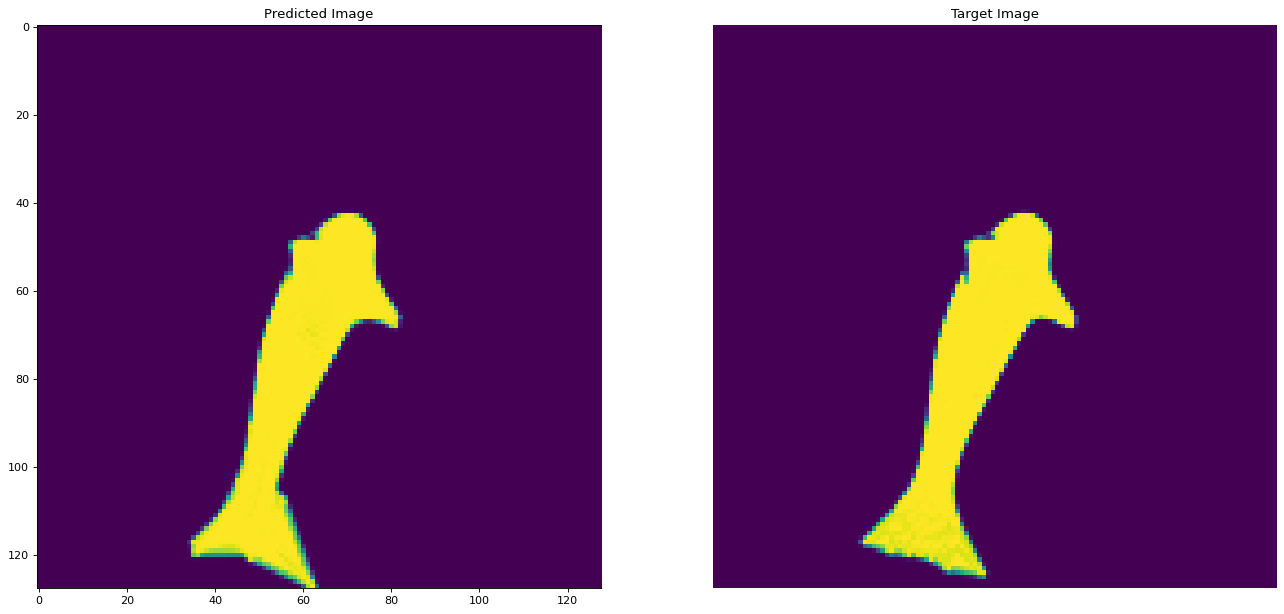

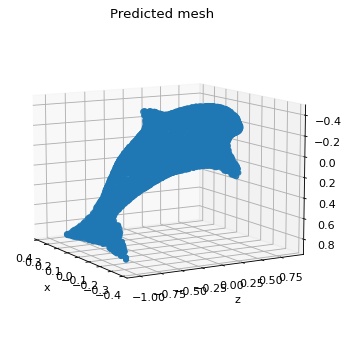

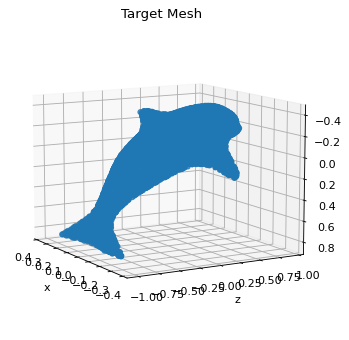

Visualizing Predicted Mesh and Target mesh as point_cloud 
At Iteration 1800: 



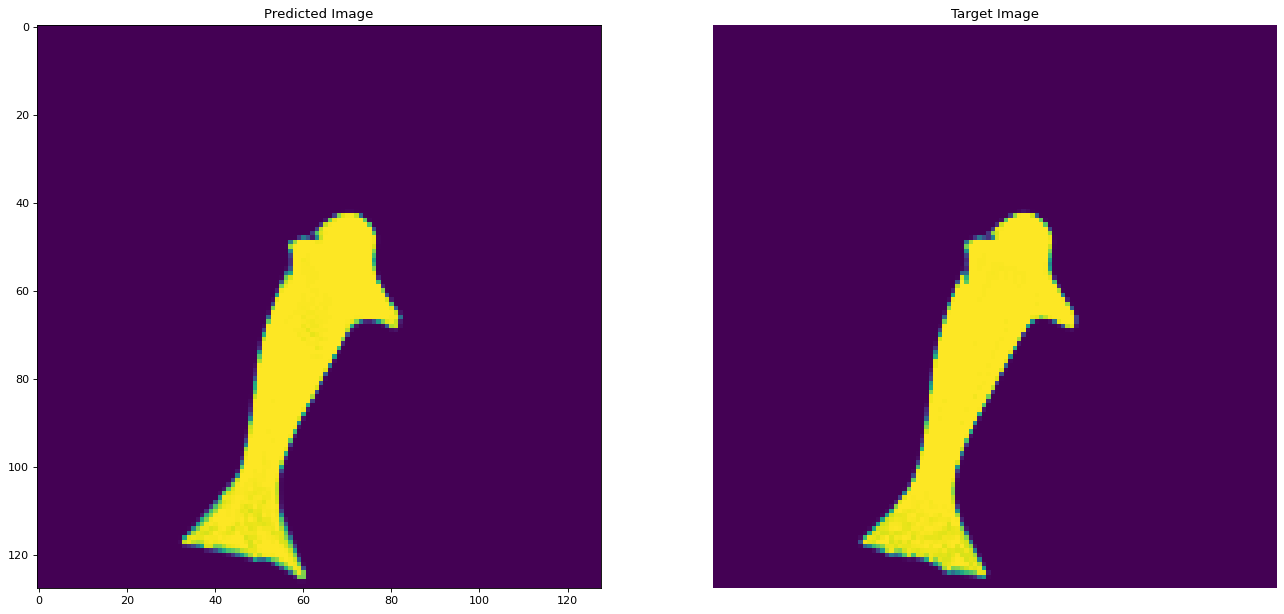

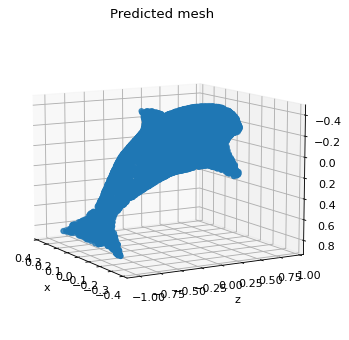

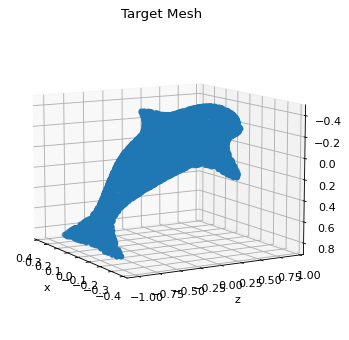

Visualizing Predicted Mesh and Target mesh as point_cloud 
At Iteration 1900: 



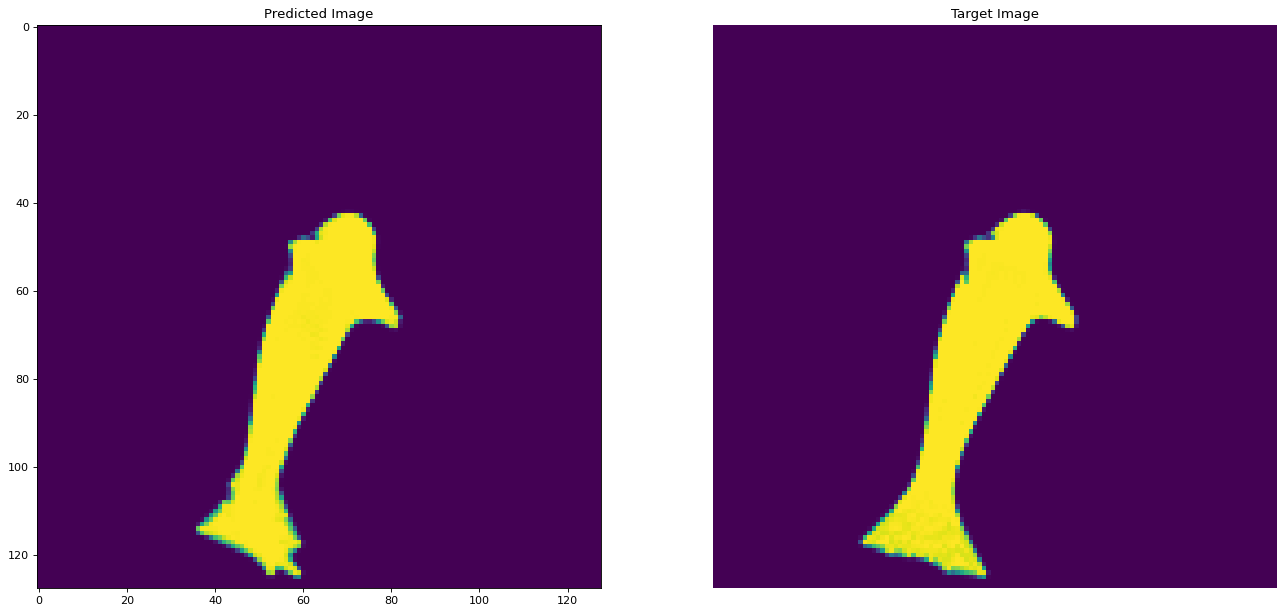

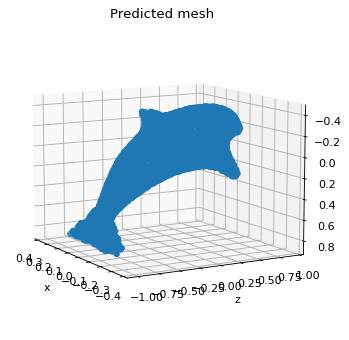

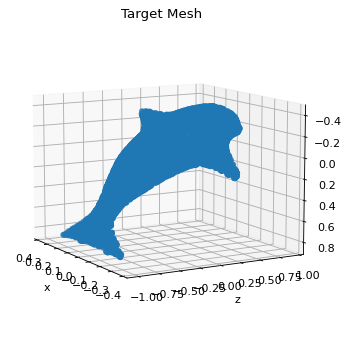

Visualizing Predicted Mesh and Target mesh as point_cloud 


In [ ]:
loop = tqdm(range(Niter))

for i in loop:
    # Initialize optimizer
    optimizer.zero_grad()

    # Deform the mesh
    new_src_mesh = src_mesh.offset_verts(deform_verts)

    # Losses to smooth /regularize the mesh shape
    loss = {k: torch.tensor(0.0, device=device) for k in losses}
    update_mesh_shape_prior_losses(new_src_mesh, loss)

    # Compute the average silhouette loss over two random views, as the average
    # squared L2 distance between the predicted silhouette and the target
    # silhouette from our dataset
    for j in np.random.permutation(num_views).tolist()[:num_views_per_iteration]:
        images_predicted = renderer_silhouette(new_src_mesh, cameras=target_cameras[j], lights=lights)
        predicted_silhouette = images_predicted[..., 3]
        loss_silhouette = ((predicted_silhouette - target_silhouette[j]) ** 2).mean()
        loss["silhouette"] += loss_silhouette / num_views_per_iteration

    # Weighted sum of the losses
    sum_loss = torch.tensor(0.0, device=device)
    for k, l in loss.items():
        sum_loss += l * losses[k]["weight"]
        losses[k]["values"].append(float(l.detach().cpu()))


    # Print the losses
    loop.set_description("total_loss = %.6f" % sum_loss)

    # Plot mesh
    if i % plot_period == 0:
        print(f"At Iteration { i }: \n")
        visualize_prediction(new_src_mesh, silhouette=True,
                             target_image=target_silhouette[1])
    # Plot mesh
    if i % plot_period == 0:

        plot_pointcloud(new_src_mesh, title= "Predicted mesh")
        plot_pointcloud(trg_mesh, title="Target Mesh")
        print("Visualizing Predicted Mesh and Target mesh as point_cloud \n===================================================================================================================")

    # Optimization step
    sum_loss.backward()
    optimizer.step()

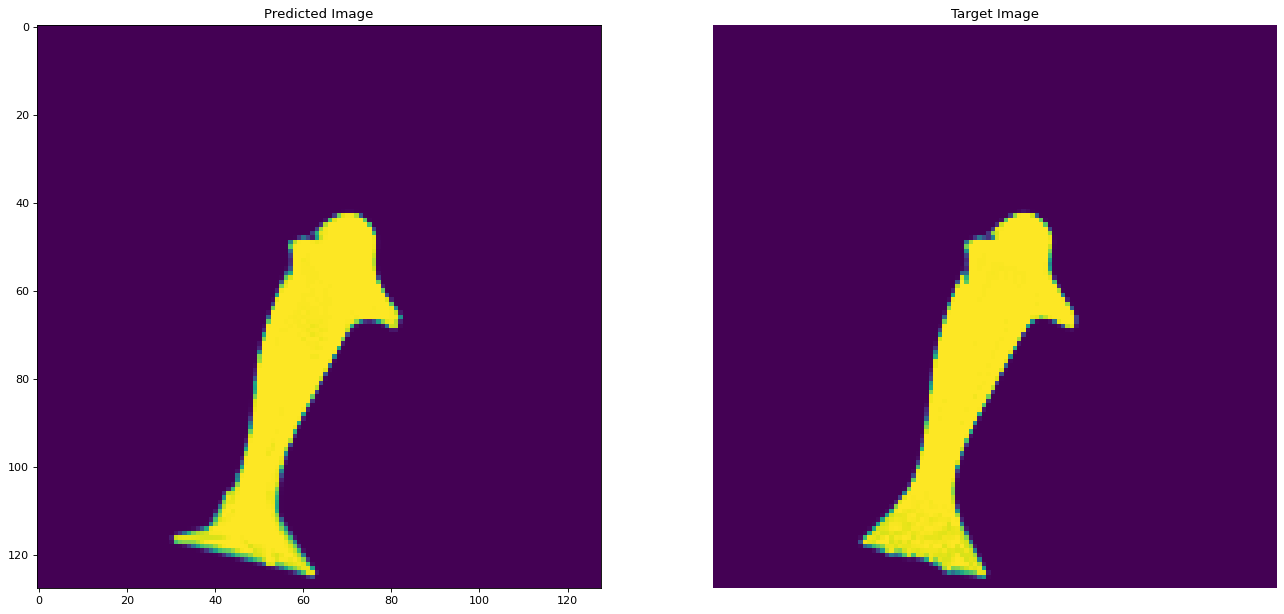

In [ ]:
visualize_prediction(new_src_mesh, silhouette=True,
                     target_image=target_silhouette[1])

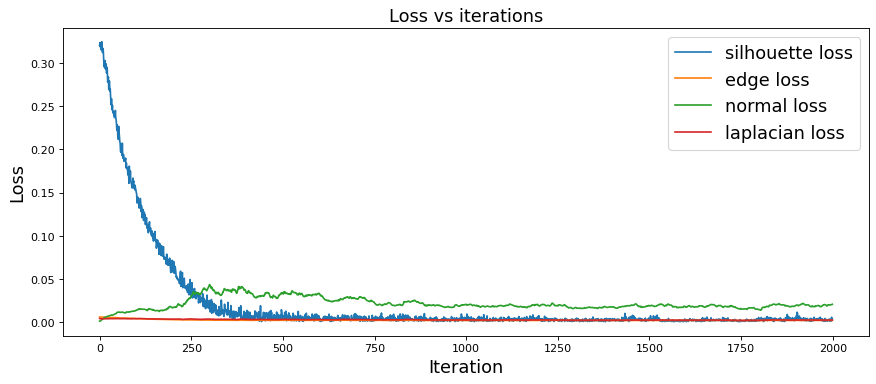

In [ ]:
plot_losses(losses)

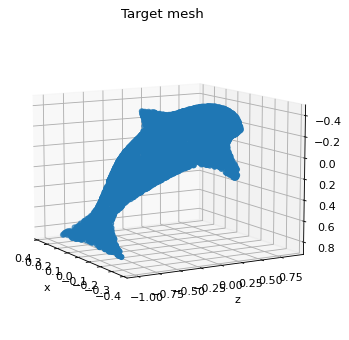

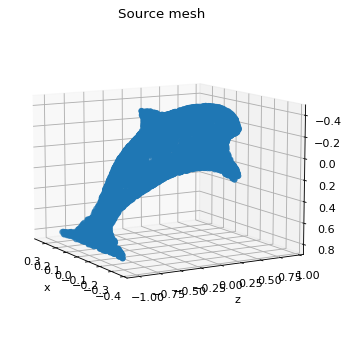

In [ ]:
# %matplotlib notebook
plot_pointcloud(trg_mesh, "Target mesh")
plot_pointcloud(new_src_mesh, "Source mesh")

# Introducing Adverserial Loss

**Second Approach:** In the second approach we introduce adversarial loss into our optimization loop. It means we must design a separate discriminator network. The network we design consists of for convolutional layer with instance normalization and the activation function that was chosen is leaky-Relu in between the conv2D layer and sigmoid in the end to get the classification of fake and real image. We integrate this discriminator network with the optimization loop of our algorithm during training we feed the real 2d images of target mesh into discriminator as well as the 2d images of deformed mesh to our discriminator network. It must classify both real and fake correctly. We calculate the discriminator loss using MSE loss as criterion. In the end some weightage is also given to discriminator loss as well and combined with other losses to take the optimization step. The optimizer we choose here is not SGD but Adam optimizer because it is best known that Adam optimizer work very well when it comes to adversarial training.

In [ ]:
target_silhouette[0].shape

torch.Size([128, 128])

In [ ]:
# We initialize the source shape to be a sphere of radius 1.
src_mesh = ico_sphere(4, device)

In [ ]:

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x).view(-1)


In [ ]:
disc=Discriminator().to(device)
# opt_disc = optim.Adam(disc.parameters(),lr=1e-3, weight_decay=1e-5 )
# opt_disc = optim.SGD(disc.parameters(),lr=1.0, momentum=0.9 )
criterion = nn.MSELoss()

In [ ]:
# Number of views to optimize over in each SGD iteration
num_views_per_iteration = 4
# Number of optimization steps
Niter = 1000
# Plot period for the losses
plot_period = 100

%matplotlib inline

# Optimize using rendered silhouette image loss, mesh edge loss, mesh normal
# consistency, and mesh laplacian smoothing
losses = {"silhouette": {"weight": 1.5, "values": []},
          "disc": {"weight": 0.7, "values": []},
          "edge": {"weight": 1.0, "values": []},
          "normal": {"weight": 0.01, "values": []},
          "laplacian": {"weight": 1.0, "values": []},
         }

# Losses to smooth / regularize the mesh shape
def update_mesh_shape_prior_losses(mesh, loss):
    # and (b) the edge length of the predicted mesh
    loss["edge"] = mesh_edge_loss(mesh)

    # mesh normal consistency
    loss["normal"] = mesh_normal_consistency(mesh)

    # mesh laplacian smoothing
    loss["laplacian"] = mesh_laplacian_smoothing(mesh, method="uniform")

# We will learn to deform the source mesh by offsetting its vertices
# The shape of the deform parameters is equal to the total number of vertices in
# src_mesh
verts_shape = src_mesh.verts_packed().shape
deform_verts = torch.full(verts_shape, 0.0, device=device, requires_grad=True)

# The optimizer
# optimizer = torch.optim.SGD([{'params': [deform_verts]}, {'params': disc.parameters()}], lr=1.0, momentum=0.9)
# optimizer = torch.optim.Adam([{'params': [deform_verts]}, {'params': disc.parameters()}], lr=1e-2, weight_decay=1e-5 )
# optimizer = torch.optim.Adam([{'params': [deform_verts]} ], lr=1e-2, betas=(0.5, 0.999) )
optimizer = torch.optim.Adam([{'params': [deform_verts]}, {'params': disc.parameters()}], lr=1e-2, betas=(0.5, 0.999) )


  0%|          | 0/1000 [00:00<?, ?it/s]

At Iteration 0: 



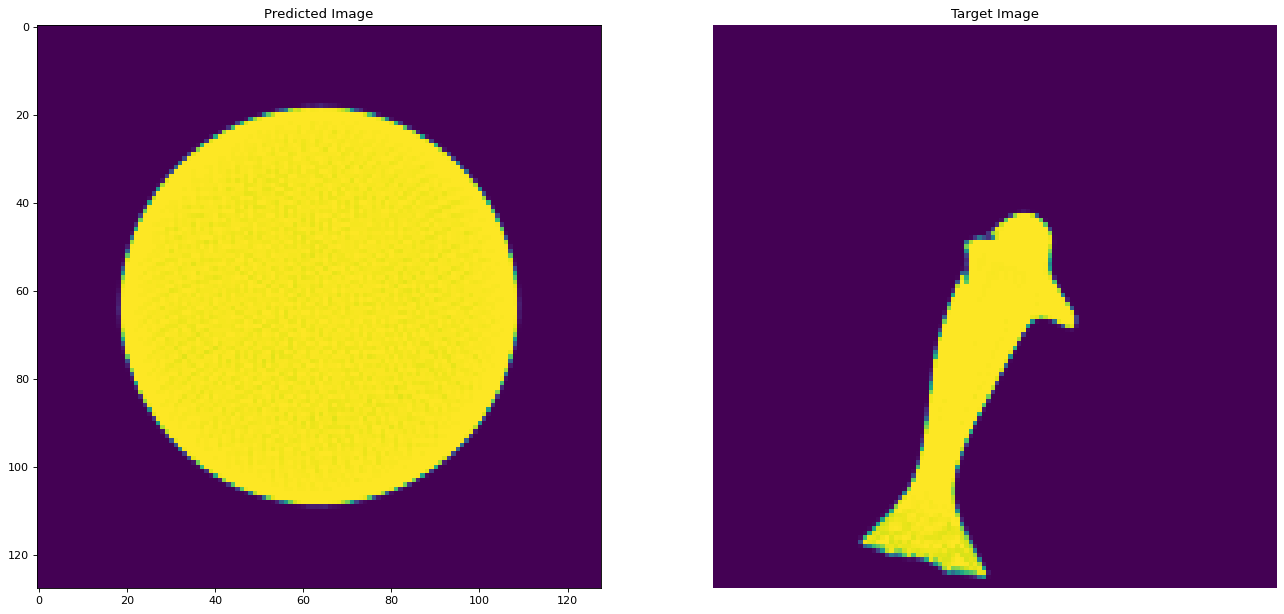

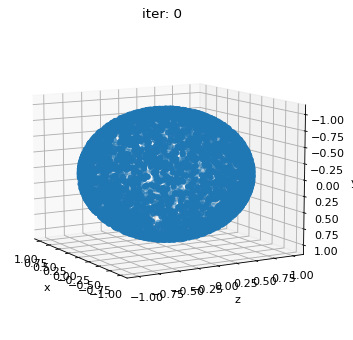

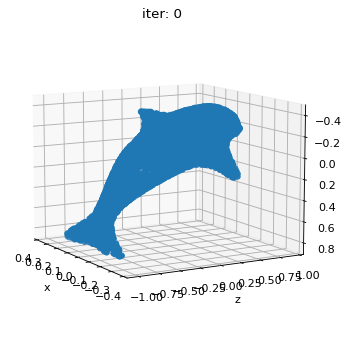

Visualizing Predicted Mesh and Target mesh as point_cloud 
At Iteration 100: 



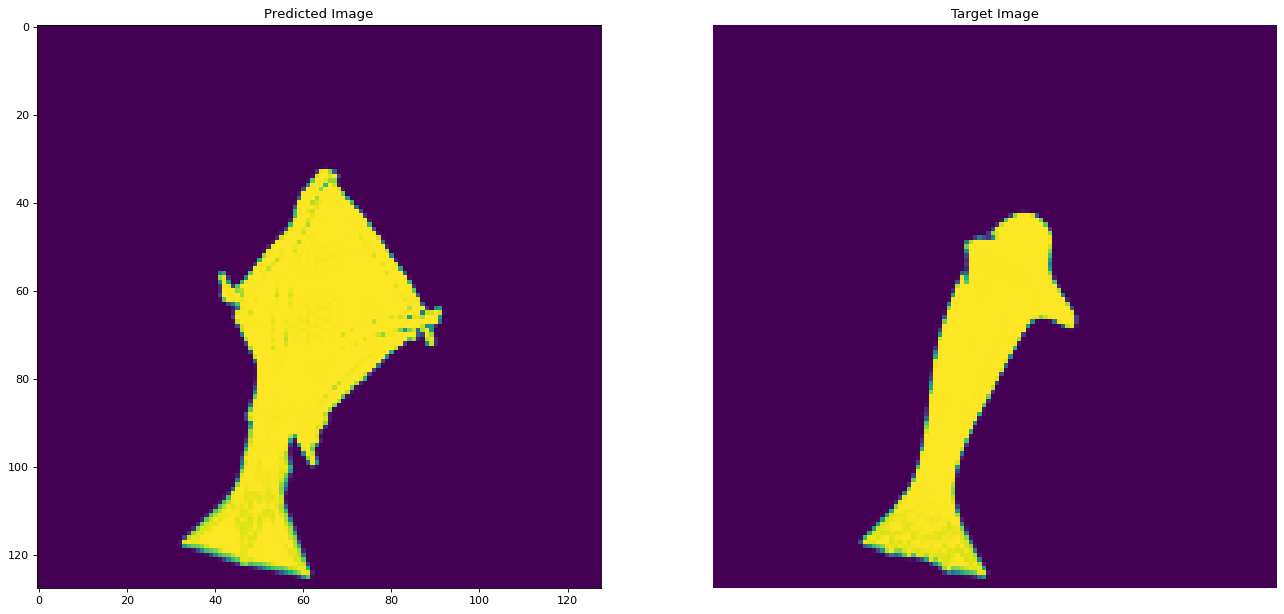

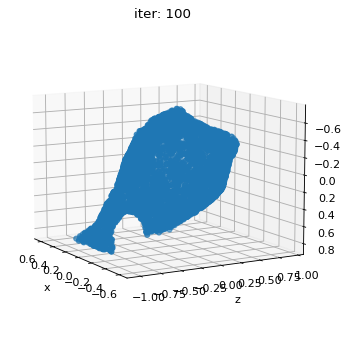

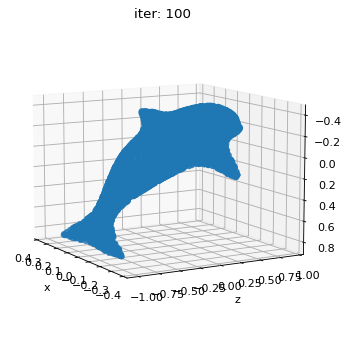

Visualizing Predicted Mesh and Target mesh as point_cloud 
At Iteration 200: 



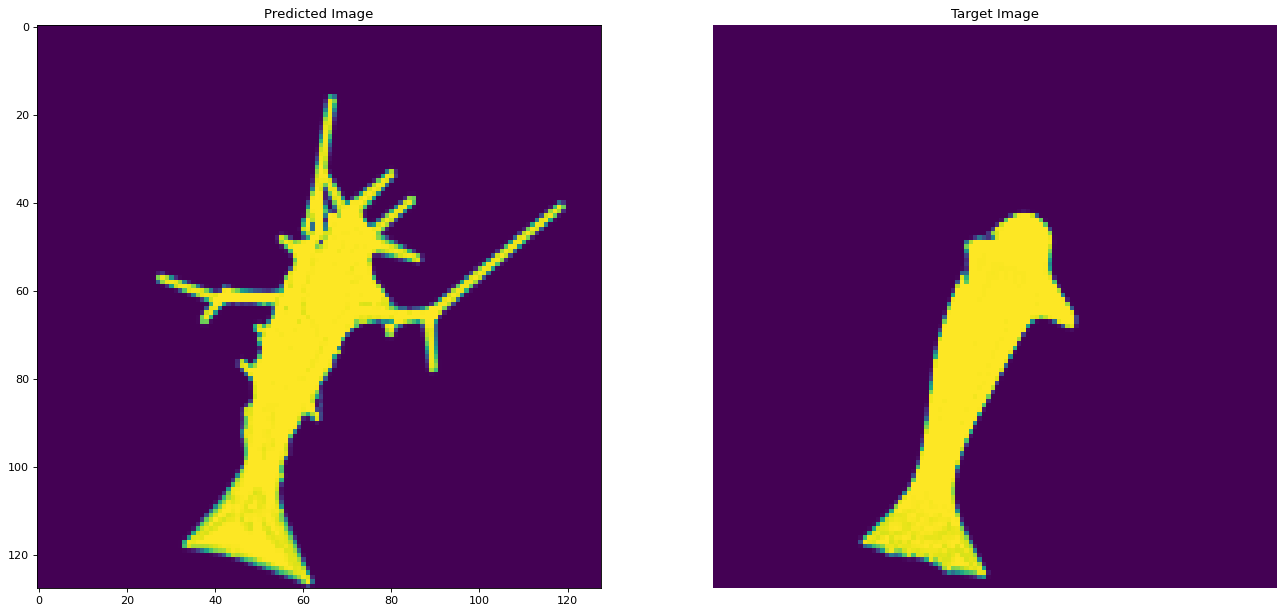

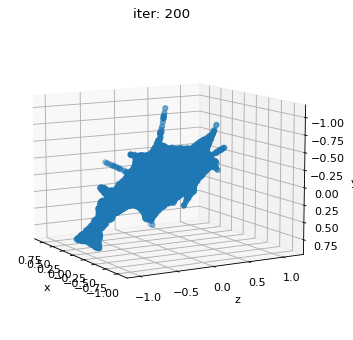

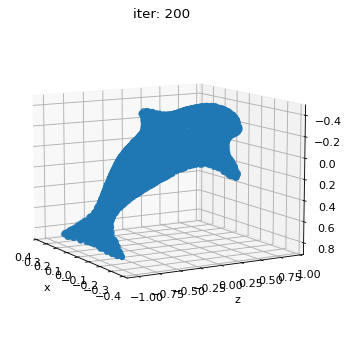

Visualizing Predicted Mesh and Target mesh as point_cloud 
At Iteration 300: 



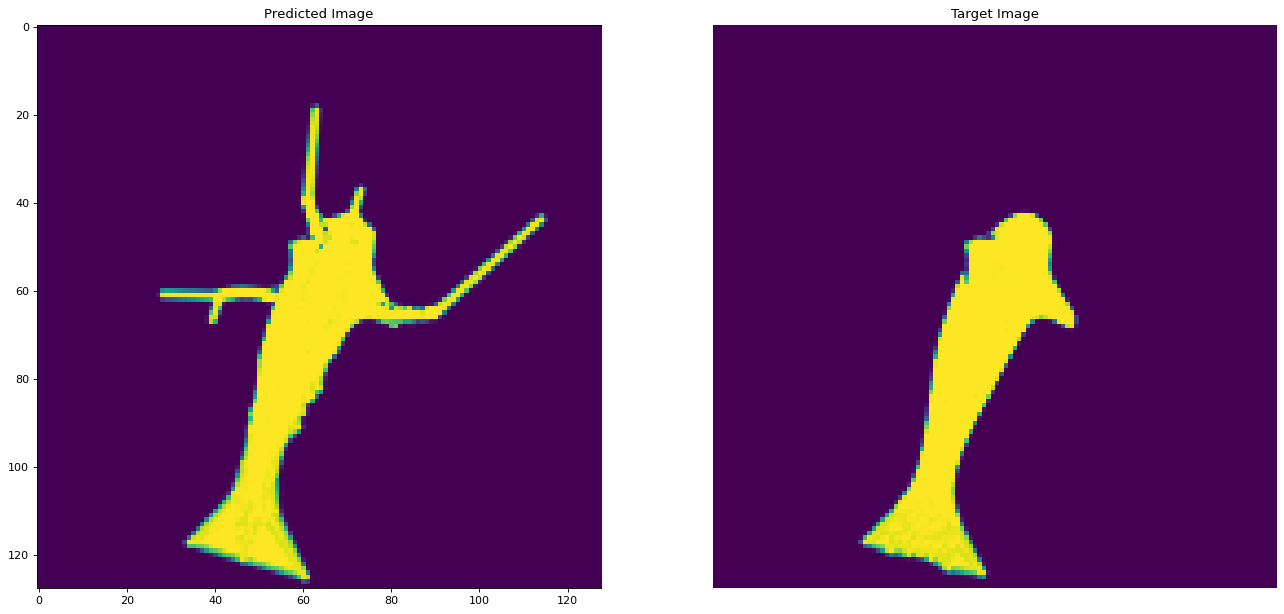

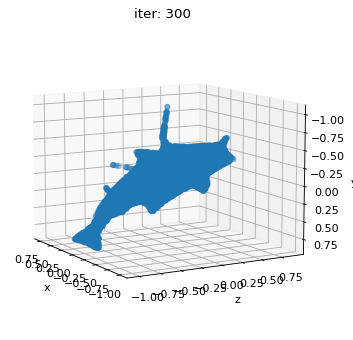

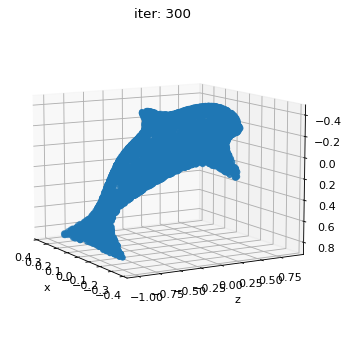

Visualizing Predicted Mesh and Target mesh as point_cloud 
At Iteration 400: 



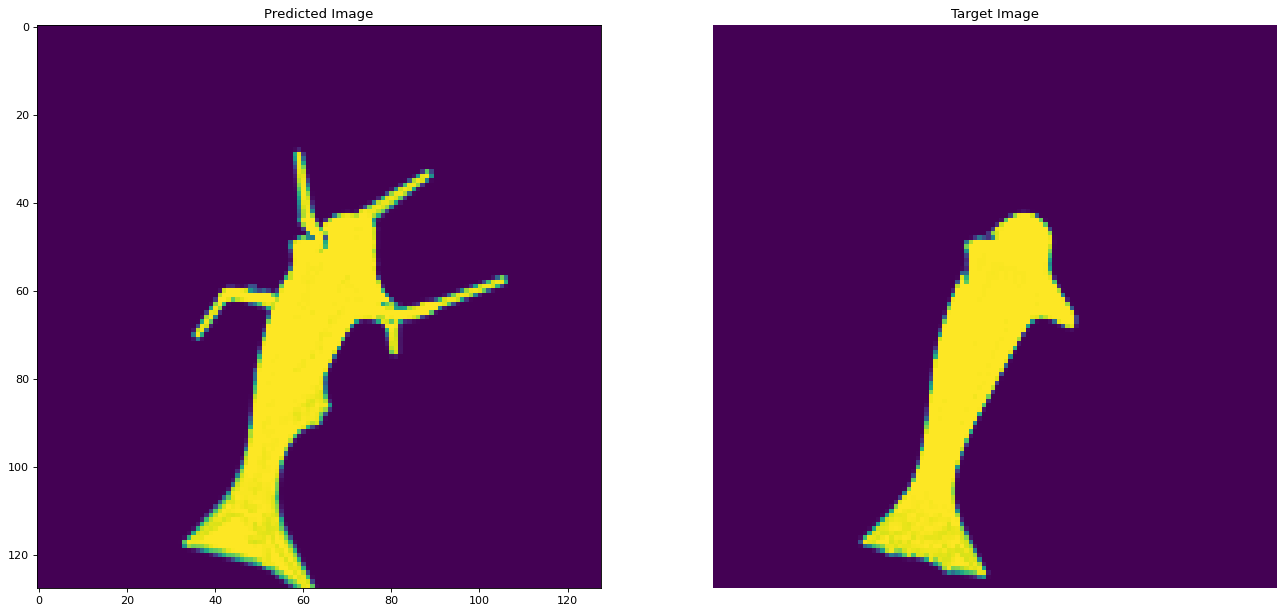

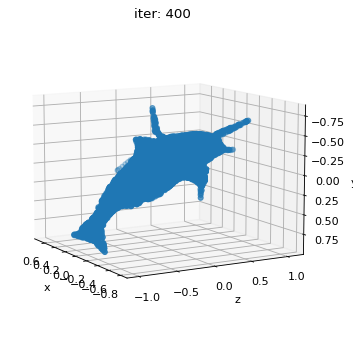

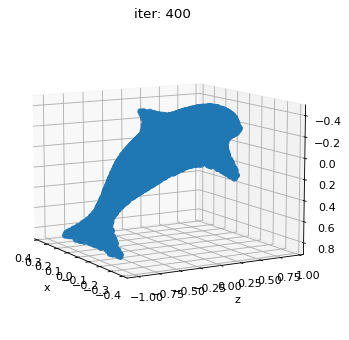

Visualizing Predicted Mesh and Target mesh as point_cloud 
At Iteration 500: 



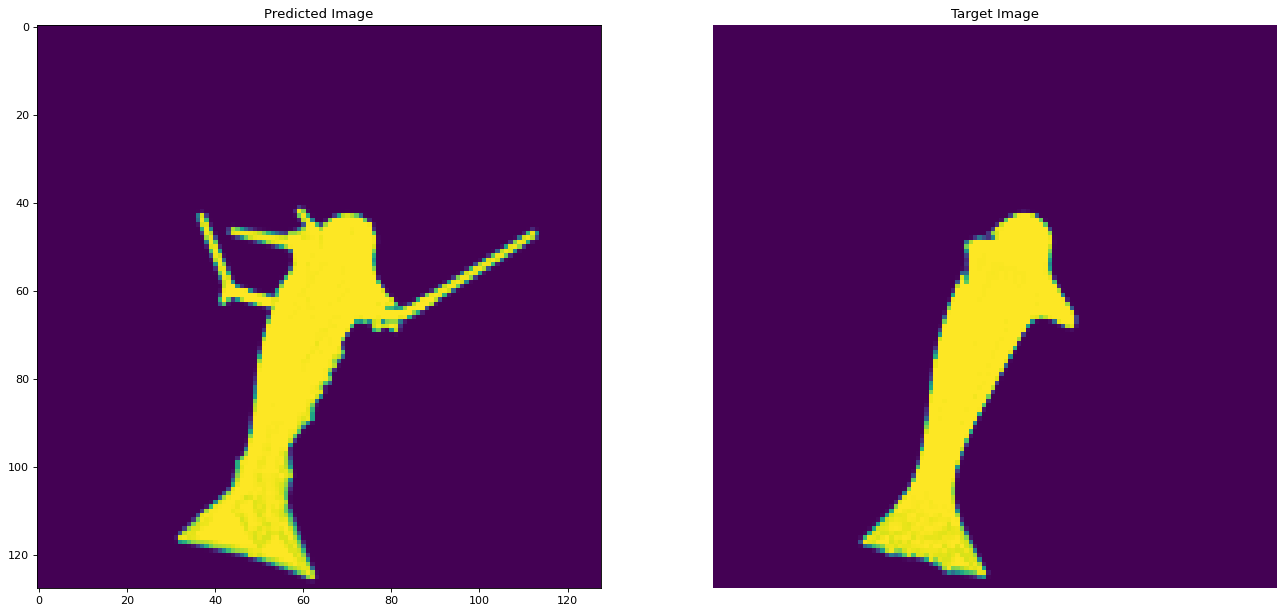

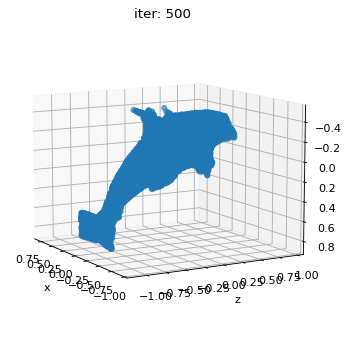

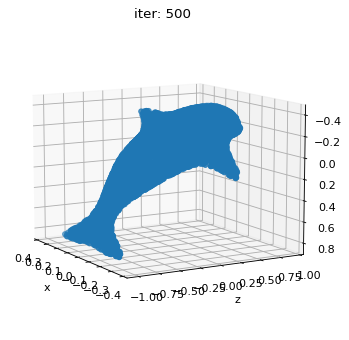

Visualizing Predicted Mesh and Target mesh as point_cloud 
At Iteration 600: 



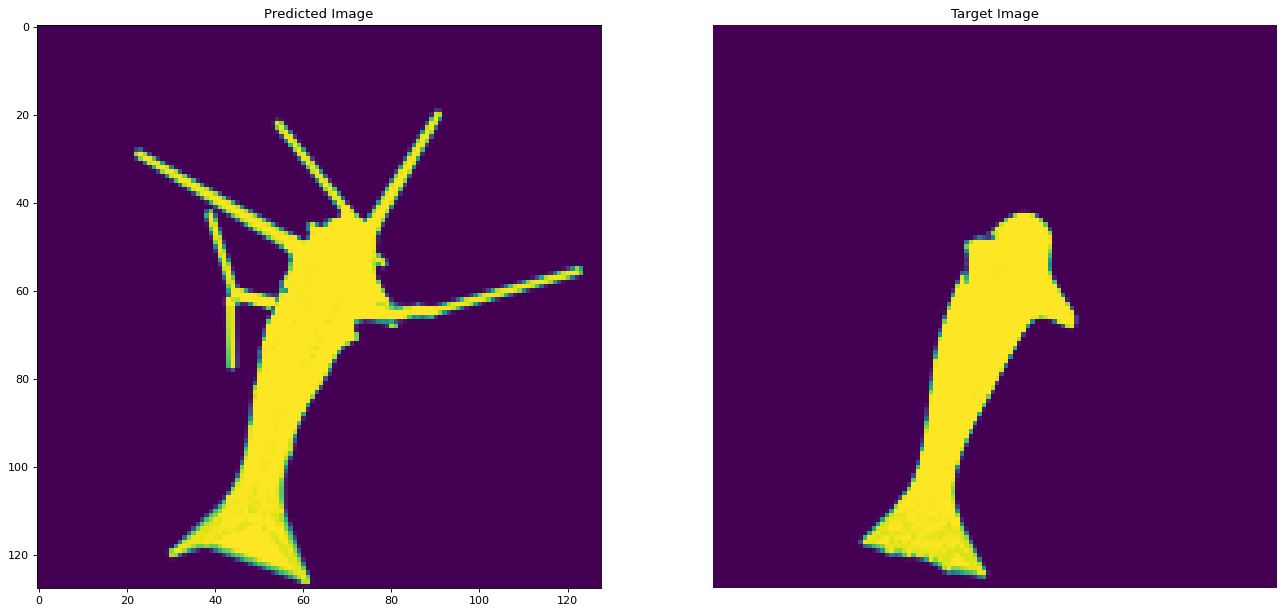

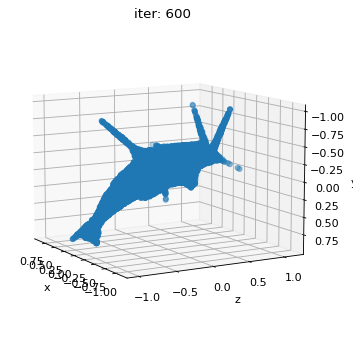

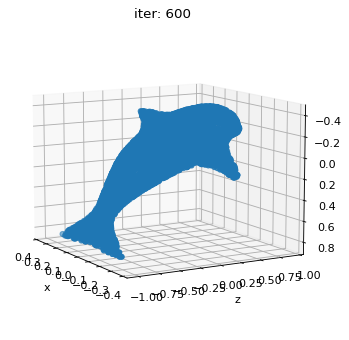

Visualizing Predicted Mesh and Target mesh as point_cloud 
At Iteration 700: 



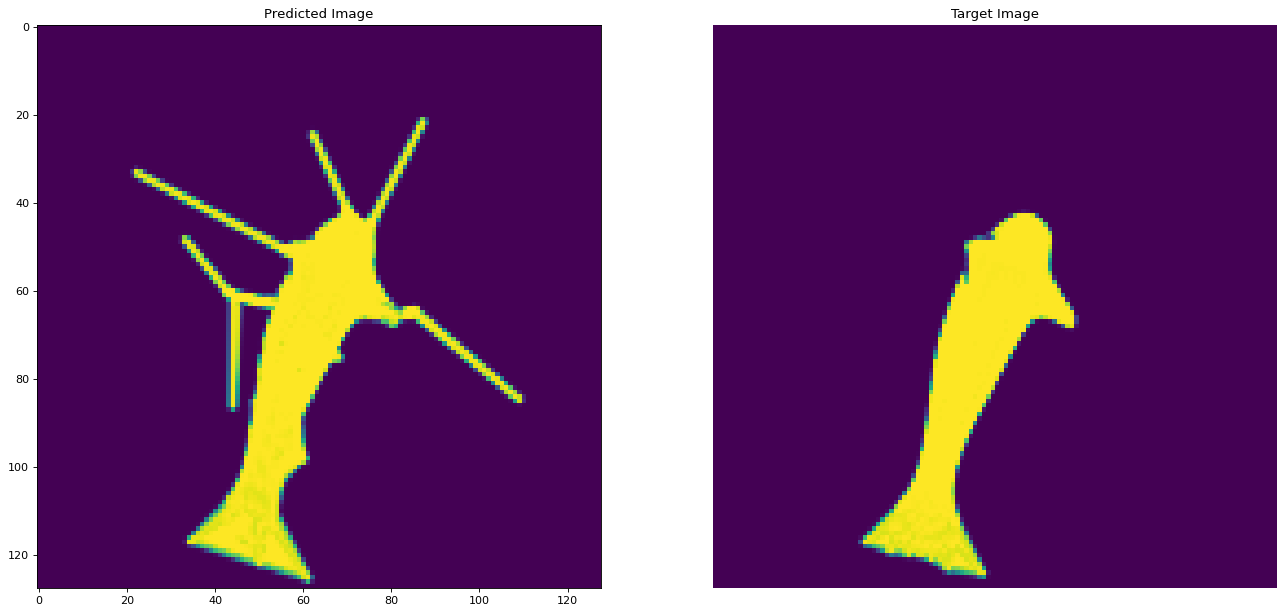

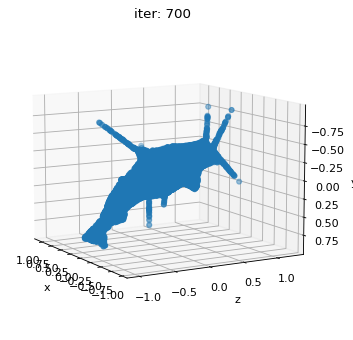

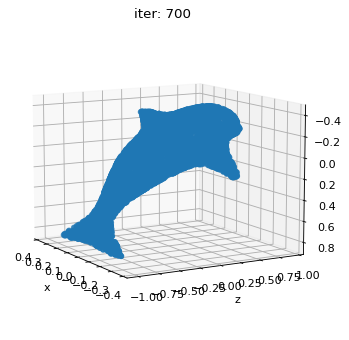

Visualizing Predicted Mesh and Target mesh as point_cloud 
At Iteration 800: 



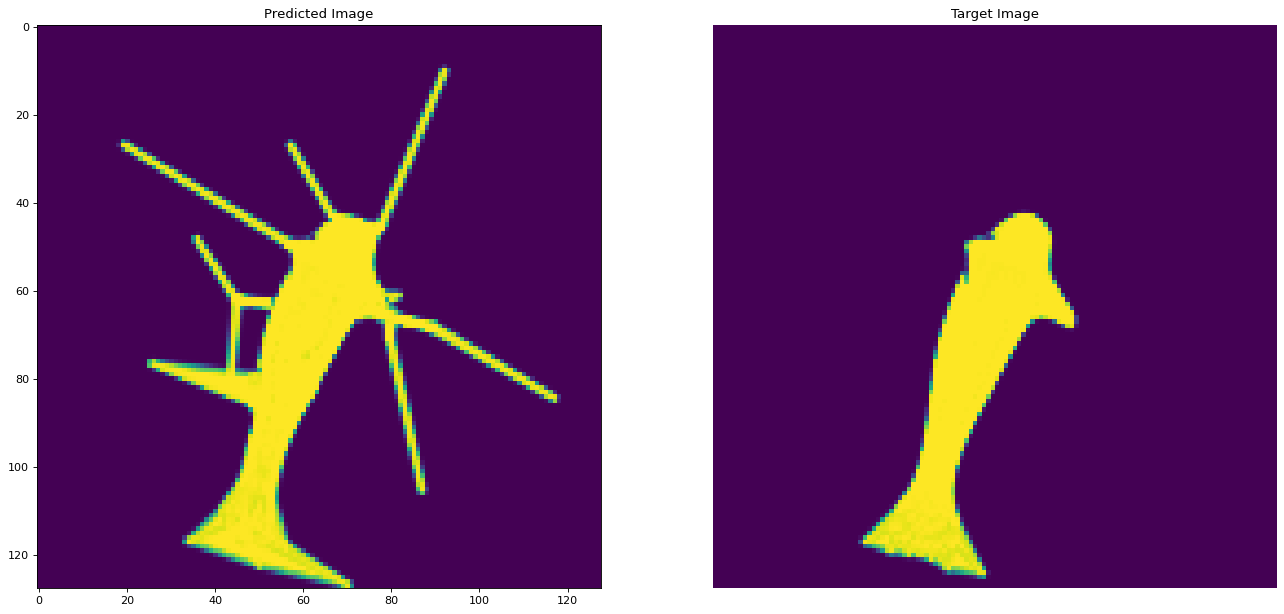

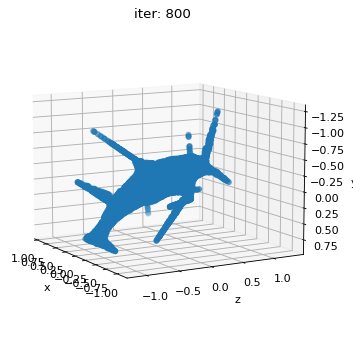

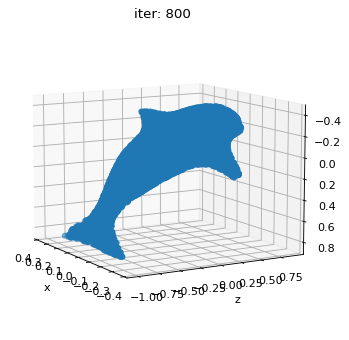

Visualizing Predicted Mesh and Target mesh as point_cloud 
At Iteration 900: 



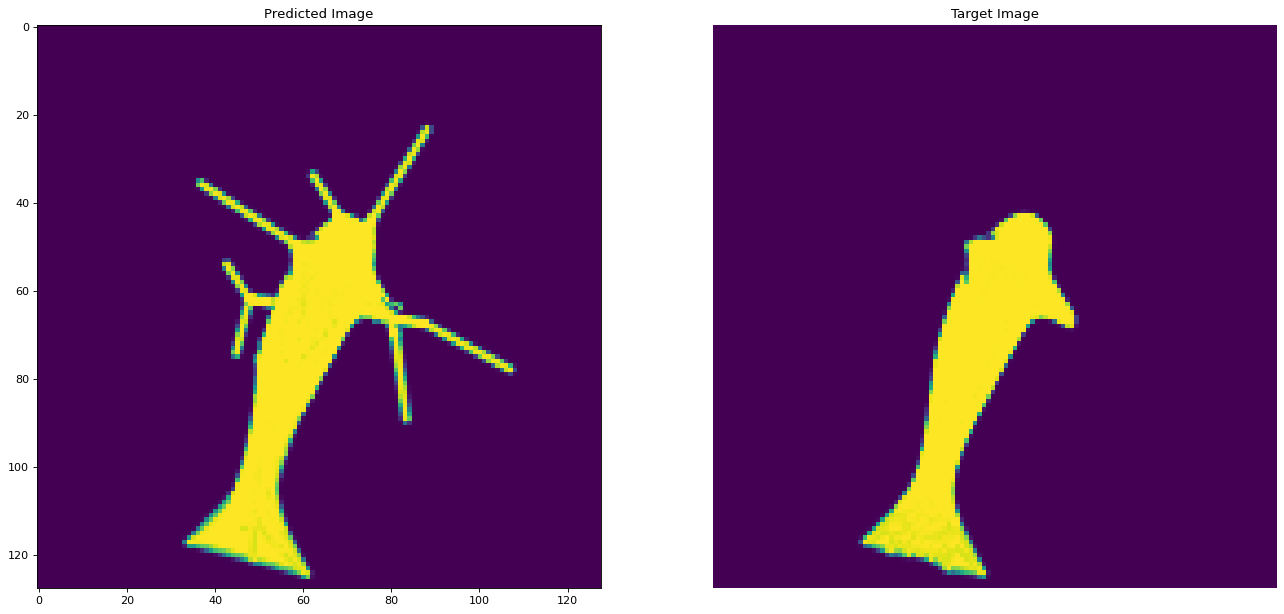

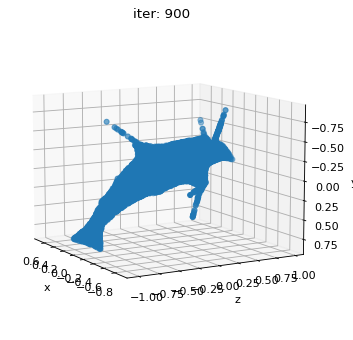

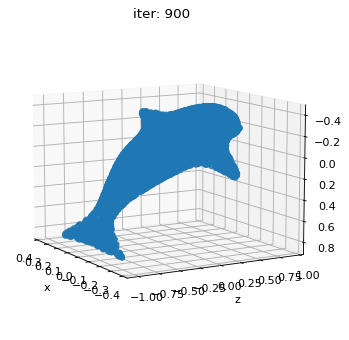

Visualizing Predicted Mesh and Target mesh as point_cloud 


In [ ]:
loop = tqdm(range(Niter))

for i in loop:
    # Initialize optimizer
    optimizer.zero_grad()

    # Deform the mesh
    new_src_mesh = src_mesh.offset_verts(deform_verts)

    # Losses to smooth /regularize the mesh shape
    loss = {k: torch.tensor(0.0, device=device) for k in losses}
    update_mesh_shape_prior_losses(new_src_mesh, loss)

    # Compute the average silhouette loss over two random views, as the average
    # squared L2 distance between the predicted silhouette and the target
    # silhouette from our dataset
    for j in np.random.permutation(num_views).tolist()[:num_views_per_iteration]:
        images_predicted = renderer_silhouette(new_src_mesh, cameras=target_cameras[j], lights=lights)
        predicted_silhouette = images_predicted[..., 3]
        loss_silhouette = ((predicted_silhouette - target_silhouette[j]) ** 2).mean()
        loss["silhouette"] += loss_silhouette / num_views_per_iteration

        disc_real = disc(target_silhouette[j].unsqueeze(0).unsqueeze(0)).view(-1) # output of sigmoid function after feeding REAL image
        lossD_real = criterion(disc_real, torch.ones_like(disc_real)) # discrmiminater must detect this as real image so in place of actual output we put 1, ouput of dicrminater shoul also be one
        disc_fake = disc(predicted_silhouette.unsqueeze(0)).view(-1)# output of sigmoid function after feeding FAKE image
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))# discrmiminater must detect this as Fake image so in place of actual output we put 0, ouput of dicrminater shoul also be zero
        t_disc_loss = (lossD_real+lossD_fake)/2

        loss["disc"] += t_disc_loss / num_views_per_iteration



    # Weighted sum of the losses
    sum_loss = torch.tensor(0.0, device=device)
    for k, l in loss.items():
        sum_loss += l * losses[k]["weight"]
        losses[k]["values"].append(float(l.detach().cpu()))


    # Print the losses
    loop.set_description("total_loss = %.6f" % sum_loss)

    # Plot mesh
    if i % plot_period == 0:
        print(f"At Iteration { i }: \n")
        visualize_prediction(new_src_mesh, silhouette=True,
                             target_image=target_silhouette[1])
    # Plot mesh
    if i % plot_period == 0:

        plot_pointcloud(new_src_mesh, title="iter: %d" % i)
        plot_pointcloud(trg_mesh, title="iter: %d" % i)
        print("Visualizing Predicted Mesh and Target mesh as point_cloud \n===================================================================================================================")

    # Optimization step
    sum_loss.backward()
    optimizer.step()

**Losses:** For the losses , we also maintain the record all the losses over each iteration including the newly introduce discriminator loss. In figure 9 you can see all the losses, which is very different than the losses we saw in earlier approach. This is only because of our discriminator network which is playing a min-max game between the training loop. Due to this we are only concern with the visual effects of deformed mesh rather than the numerical values of losses.

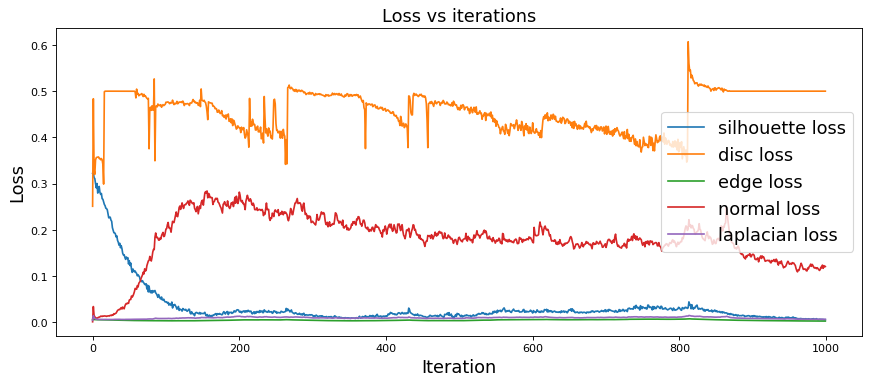

In [ ]:
plot_losses(losses)

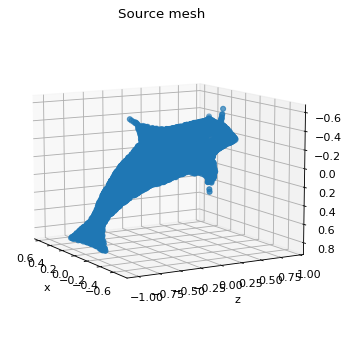

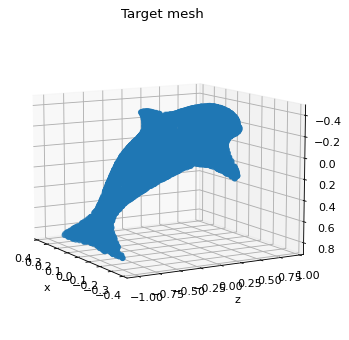

In [ ]:
# %matplotlib notebook
plot_pointcloud(new_src_mesh, "Source mesh")
plot_pointcloud(trg_mesh, "Target mesh")

# Third Approach
In the third and the last approach we just tried to change the discriminator network try to make it more complex, because the result that we got from the second approach was a bit fuzzy and rough. So, what we did first was to introduce a couple of more convolutional layers into it and the we try to integrate a self-attention mechanism into our discriminator network. Convolutional layers have limited receptive field, which can make it difficult for the discriminator to capture larger structures in the image. This is where the self-attention mechanism comes in. The self-attention mechanism allows the discriminator to focus on specific regions of the image that are relevant for a particular task. This is like how attention works in language translation and image captioning, where the model focuses on different parts of the input to generate the output. The rest of the algorithm work just as the previous one, we compute the discriminator loss; combine it with other four losses, each loss has its own weightage for contribution in optimization step. After that we backpropagate to learn the deform vertices.

In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()

        self.query = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.key = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.value = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        batch_size, channels, height, width = x.size()

        query = self.query(x).view(batch_size, -1, height * width).permute(0, 2, 1)
        key = self.key(x).view(batch_size, -1, height * width)
        value = self.value(x).view(batch_size, -1, height * width)

        attention_scores = torch.bmm(query, key)
        attention_probs = self.softmax(attention_scores)

        context = torch.bmm(value, attention_probs.permute(0, 2, 1))
        context = context.view(batch_size, channels, height, width)

        return context

In [ ]:

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.attention = SelfAttention(in_channels=256)

        self.model = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.attention = SelfAttention(in_channels=512)

        self.classifier = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=4, stride=2, padding=0),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.model(x)
        x = self.attention(x)
        x = self.classifier(x)
        return x.view(-1)

In [ ]:
src_mesh = ico_sphere(4, device)

In [ ]:
disc=Discriminator().to(device)
# opt_disc = optim.Adam(disc.parameters(),lr=1e-3, weight_decay=1e-5 )
# opt_disc = optim.SGD(disc.parameters(),lr=1.0, momentum=0.9 )
criterion = nn.MSELoss()

In [ ]:
# Number of views to optimize over in each SGD iteration
num_views_per_iteration = 4
# Number of optimization steps
Niter = 1000
# Plot period for the losses
plot_period = 200

%matplotlib inline

# Optimize using rendered silhouette image loss, mesh edge loss, mesh normal
# consistency, and mesh laplacian smoothing
losses = {"silhouette": {"weight": 0.3, "values": []},
          "disc": {"weight": 1.5, "values": []},
          "edge": {"weight": 0.5, "values": []},
          "normal": {"weight": 0.01, "values": []},
          "laplacian": {"weight": 0.5, "values": []},
         }

# Losses to smooth / regularize the mesh shape
def update_mesh_shape_prior_losses(mesh, loss):
    # and (b) the edge length of the predicted mesh
    loss["edge"] = mesh_edge_loss(mesh)

    # mesh normal consistency
    loss["normal"] = mesh_normal_consistency(mesh)

    # mesh laplacian smoothing
    loss["laplacian"] = mesh_laplacian_smoothing(mesh, method="uniform")

# We will learn to deform the source mesh by offsetting its vertices
# The shape of the deform parameters is equal to the total number of vertices in
# src_mesh
verts_shape = src_mesh.verts_packed().shape
deform_verts = torch.full(verts_shape, 0.0, device=device, requires_grad=True)

# The optimizer
# optimizer = torch.optim.SGD([{'params': [deform_verts]}, {'params': disc.parameters()}], lr=1.0, momentum=0.9)
# optimizer = torch.optim.Adam([{'params': [deform_verts]}, {'params': disc.parameters()}], lr=1e-2, weight_decay=1e-5 )
# optimizer = torch.optim.Adam([{'params': [deform_verts]} ], lr=1e-2, betas=(0.5, 0.999) )
optimizer = torch.optim.Adam([{'params': [deform_verts]}, {'params': disc.parameters()}], lr=1e-2, betas=(0.5, 0.999) )


  0%|          | 0/1000 [00:00<?, ?it/s]

At Iteration 0: 



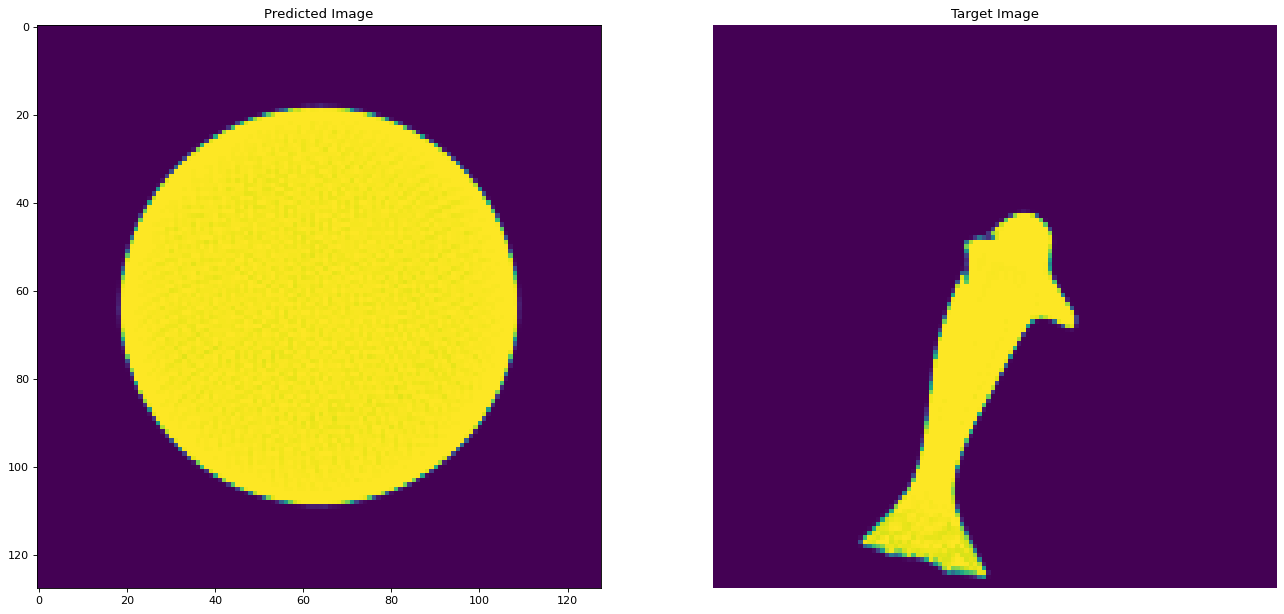

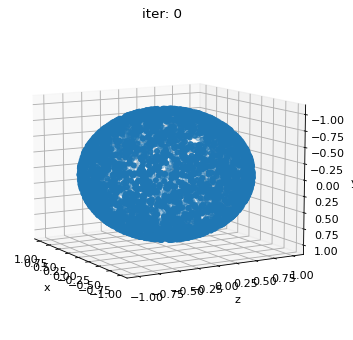

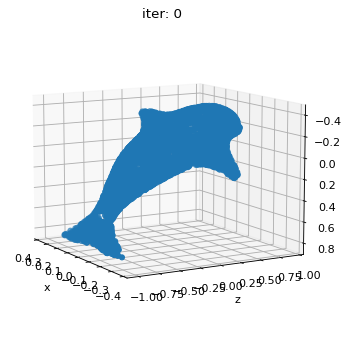

Visualizing Predicted Mesh and Target mesh as point_cloud 
At Iteration 200: 



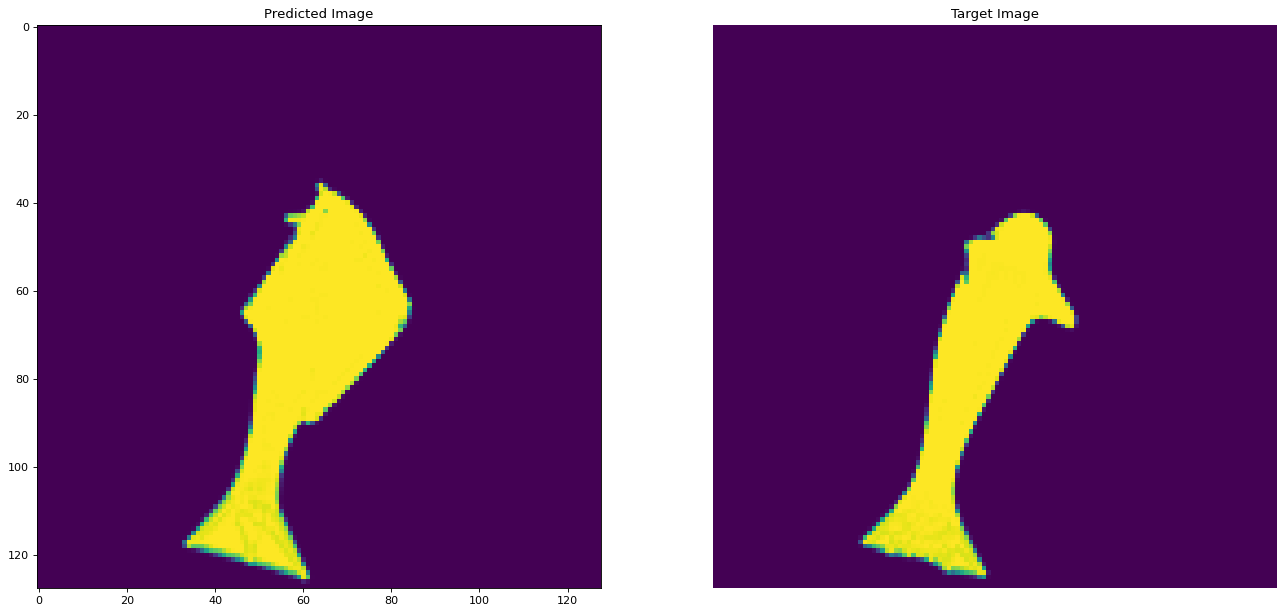

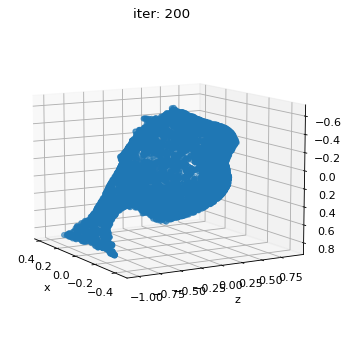

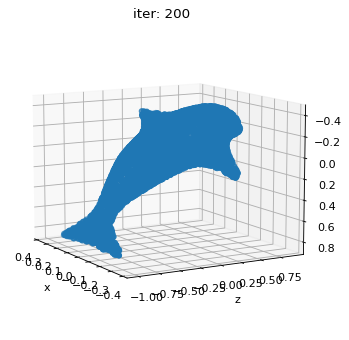

Visualizing Predicted Mesh and Target mesh as point_cloud 
At Iteration 400: 



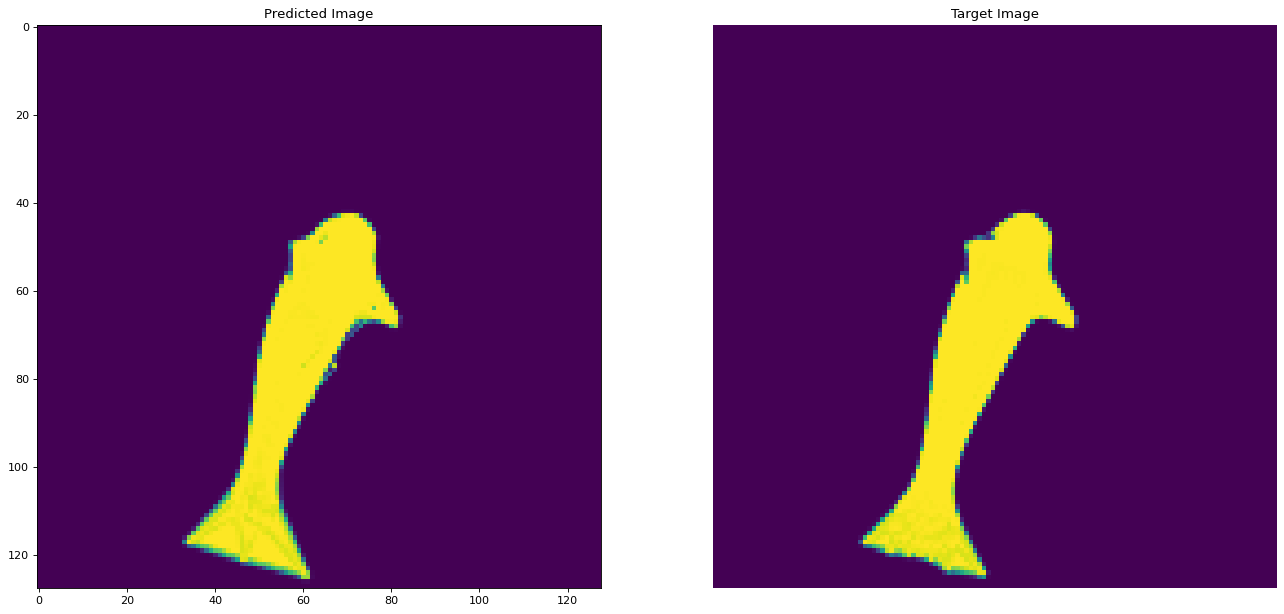

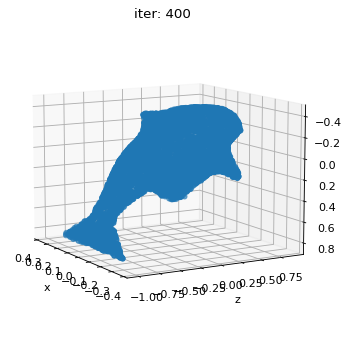

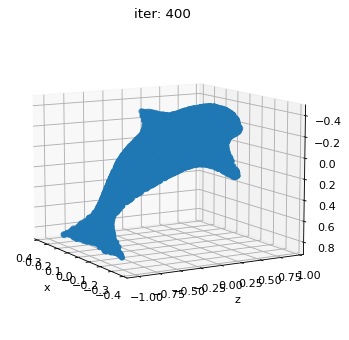

Visualizing Predicted Mesh and Target mesh as point_cloud 
At Iteration 600: 



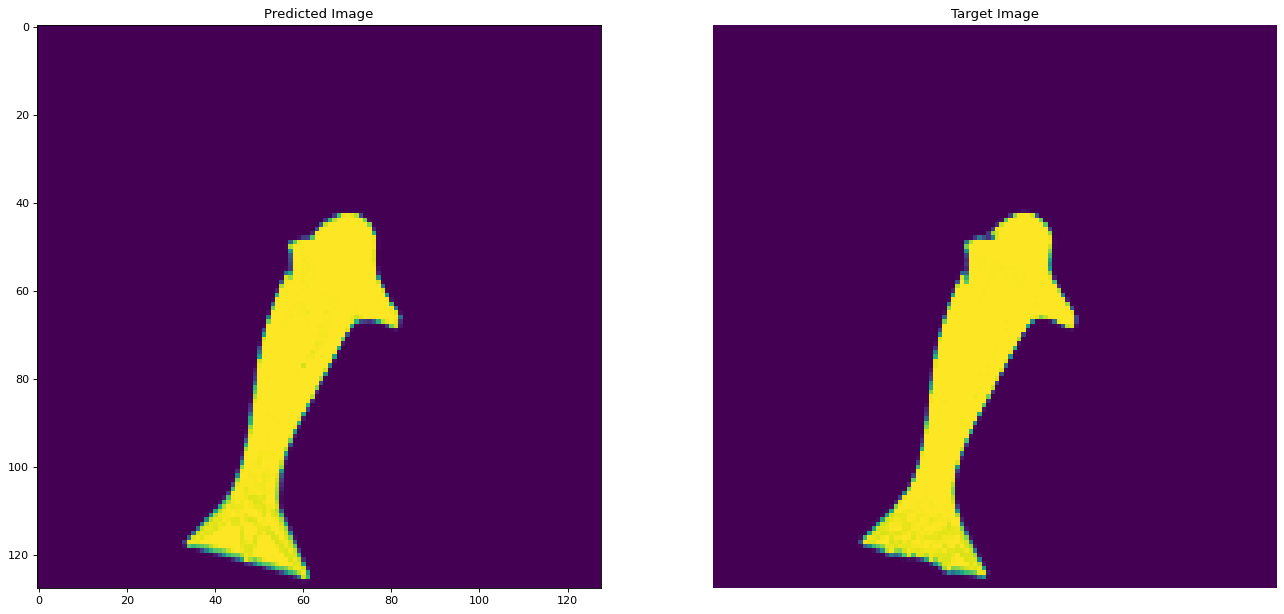

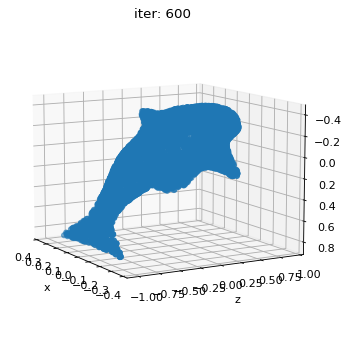

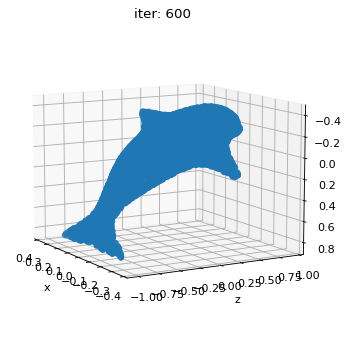

Visualizing Predicted Mesh and Target mesh as point_cloud 
At Iteration 800: 



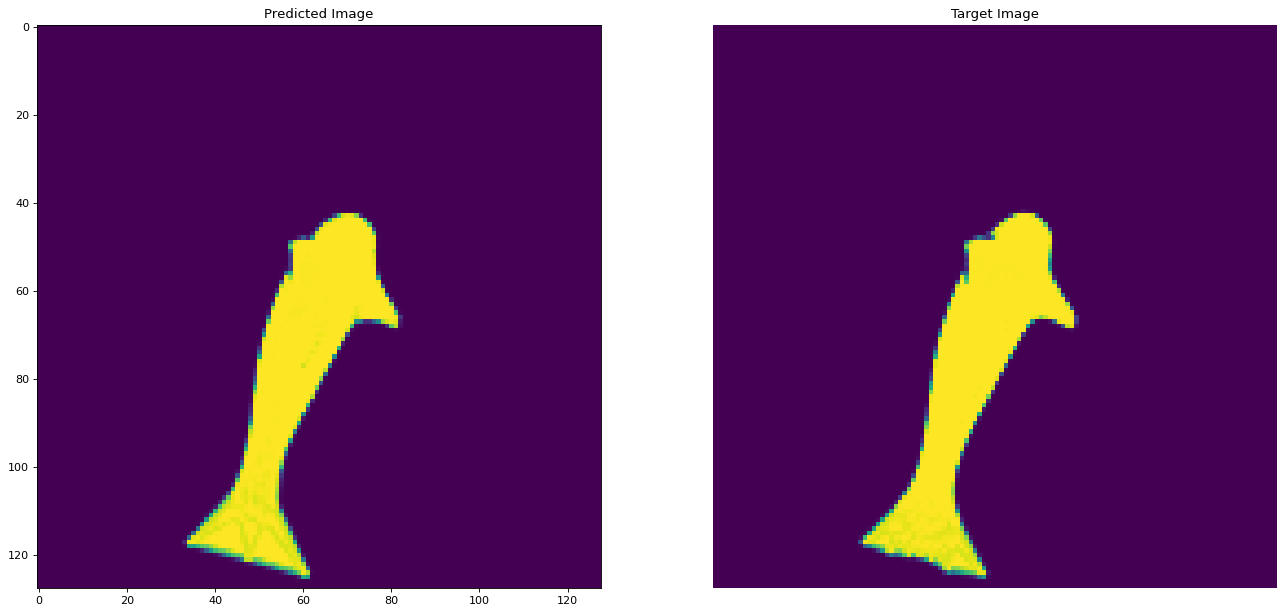

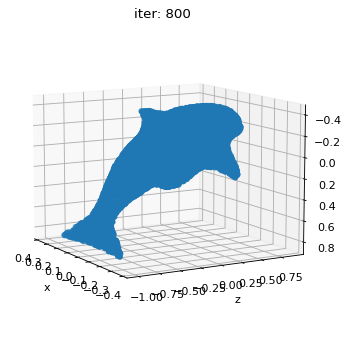

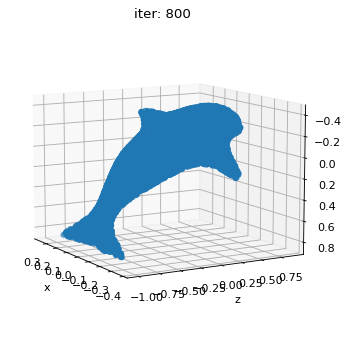

Visualizing Predicted Mesh and Target mesh as point_cloud 


In [ ]:
loop = tqdm(range(Niter))

for i in loop:
    # Initialize optimizer
    optimizer.zero_grad()

    # Deform the mesh
    new_src_mesh = src_mesh.offset_verts(deform_verts)

    # Losses to smooth /regularize the mesh shape
    loss = {k: torch.tensor(0.0, device=device) for k in losses}
    update_mesh_shape_prior_losses(new_src_mesh, loss)

    # Compute the average silhouette loss over two random views, as the average
    # squared L2 distance between the predicted silhouette and the target
    # silhouette from our dataset
    for j in np.random.permutation(num_views).tolist()[:num_views_per_iteration]:
        images_predicted = renderer_silhouette(new_src_mesh, cameras=target_cameras[j], lights=lights)
        predicted_silhouette = images_predicted[..., 3]
        loss_silhouette = ((predicted_silhouette - target_silhouette[j]) ** 2).mean()
        loss["silhouette"] += loss_silhouette / num_views_per_iteration

        disc_real = disc(target_silhouette[j].unsqueeze(0).unsqueeze(0)).view(-1) # output of sigmoid function after feeding REAL image
        lossD_real = criterion(disc_real, torch.ones_like(disc_real)) # discrmiminater must detect this as real image so in place of actual output we put 1, ouput of dicrminater shoul also be one
        disc_fake = disc(predicted_silhouette.unsqueeze(0)).view(-1)# output of sigmoid function after feeding FAKE image
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))# discrmiminater must detect this as Fake image so in place of actual output we put 0, ouput of dicrminater shoul also be zero
        t_disc_loss = (lossD_real+lossD_fake)/2

        loss["disc"] += t_disc_loss / num_views_per_iteration



    # Weighted sum of the losses
    sum_loss = torch.tensor(0.0, device=device)
    for k, l in loss.items():
        sum_loss += l * losses[k]["weight"]
        losses[k]["values"].append(float(l.detach().cpu()))


    # Print the losses
    loop.set_description("total_loss = %.6f" % sum_loss)

    # Plot mesh
    if i % plot_period == 0:
        print(f"At Iteration { i }: \n")
        visualize_prediction(new_src_mesh, silhouette=True,
                             target_image=target_silhouette[1])
    # Plot mesh
    if i % plot_period == 0:

        plot_pointcloud(new_src_mesh, title="iter: %d" % i)
        plot_pointcloud(trg_mesh, title="iter: %d" % i)
        print("Visualizing Predicted Mesh and Target mesh as point_cloud \n===================================================================================================================")

    # Optimization step
    sum_loss.backward()
    optimizer.step()

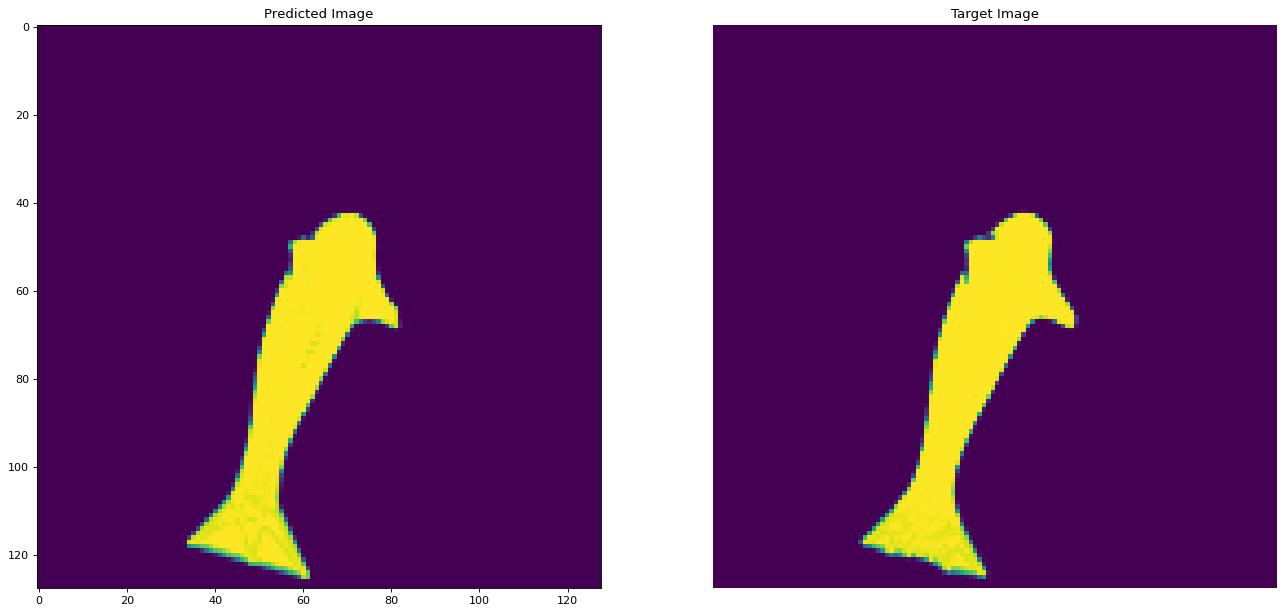

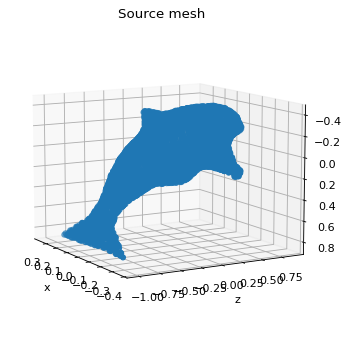

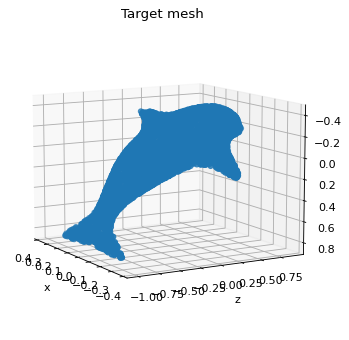

In [ ]:
visualize_prediction(new_src_mesh, silhouette=True,
                     target_image=target_silhouette[1])
# %matplotlib notebook
plot_pointcloud(new_src_mesh, "Source mesh")
plot_pointcloud(trg_mesh, "Target mesh")

# Conclusion
In this project, we explored the task of shape deformation using 2D guidance, where a 3D object is deformed to match a target shape using only 2D images as input. We proposed three approaches to tackle this problem, each building upon the previous one. Our first approach used a simple 2D-3D approach, where we fed 2D silhouette images of the target mesh into our training model to deform the source mesh. Our second approach introduced adversarial loss into the optimization loop, which improved the results but still produced a slightly fuzzy output. Finally, our third approach incorporated a self-attention mechanism into the discriminator network, resulting in a smooth and visually appealing deformed mesh.

Through our experiments, we demonstrated the effectiveness of our approaches in deforming 3D objects using 2D guidance. We showed that by incorporating adversarial loss and self-attention mechanisms, we can improve the quality of the deformed mesh and reduce the training time, but it should also be noted that this can also lead to mode collapse which I faced it many times during experimenting with the weights of the losses. This work has potential applications in various fields, including computer-aided design, computer graphics, and robotics.

Future work includes exploring other techniques to improve the deformation results, such as using more advanced neural network architectures or incorporating additional constraints into the optimization process. Additionally, we plan to extend our approach to handle more complex shapes and scenes, and to investigate its applicability to real-world problems. Overall, we believe that our work represents an important step towards developing more sophisticated and versatile shape deformation algorithms that can be used in a wide range of applications.